In [37]:
# imports
import os
import math
import dill
from itertools import permutations, combinations

import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression as linreg

import suite2p as s2p

import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basedir_VR = '/home/mplitt/VR_scratch'
figdir_local = '/home/mplitt/Fig_scratch/YMaze/behavior'
figdir_remote = '/STX3_2P_results/YMaze/behavior'

In [3]:

def antic_consum_licks(_sess):
    
    reward_mask = sess.vr_data['reward']._values>0
    reward_start = np.argwhere(reward_mask).ravel()
    reward_end = (reward_start + int(2*sess.scan_info['frame_rate'])).astype(np.int)

    consum_mask = np.zeros(reward_mask.shape)>0
    for (start,end) in zip(reward_start,reward_end):
        consum_mask[start:end]=True

    antic_licks = np.copy(sess.vr_data['lick']._values)
    antic_licks[consum_mask]=0
    
    sess.add_timeseries(antic_licks=antic_licks, licks = sess.vr_data['lick']._values, speed = sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix(('antic_licks','speed'),'t',mat_only=True)
    
    
    
    antic_lick_positions = np.zeros(sess.timeseries['licks'].shape)*np.nan
    antic_lick_mask = sess.timeseries['antic_licks']>0
    antic_lick_positions[antic_lick_mask] = sess.vr_data['t']._values[antic_lick_mask.ravel()]
    sess.add_timeseries(antic_lick_positions=antic_lick_positions)
    
def get_probes_and_omissions(sess_):
    
    probes = np.zeros([sess.trial_start_inds.shape[0],])
    omissions = np.zeros([sess.trial_start_inds.shape[0],])
    for trial, (start,stop, lr) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds, sess.trial_info['LR'])):
        if sess.scene in ("YMaze_RewardReversal"):
            lr = np.copy(lr)*-1
        
        pos = sess.vr_data['t'].iloc[start:stop]
        licks = sess.vr_data['lick'].iloc[start:stop]
        reward = sess.vr_data['reward'].iloc[start:stop]
        if lr == 1:
            rzone = (sess.rzone_late['tfront'], sess.rzone_late['tback'])
        else:
            rzone = (sess.rzone_early['tfront'], sess.rzone_early['tback'])
        rzone_mask = (pos>=rzone[0]) & (pos<=rzone[1])
        
        r = reward.sum()
        rzone_licks = licks.loc[rzone_mask].sum()
        if r==0 and rzone_licks>0:
            probes[trial]=1
        elif r==0 and rzone_licks==0:
            omissions[trial]=1
        else:
            pass
        
        sess.trial_info.update({'probes': probes, 'omissions': omissions})
    

def single_trial_lick_metrics(sess):
    
    bin_lower_edges = sess.trial_matrices['bin_edges'][:-1]
    
    lr_early = np.nanmean(sess.trial_matrices['antic_licks'][:,(bin_lower_edges>=sess.rzone_early['t_antic']) & (bin_lower_edges<sess.rzone_early['tfront']+2)], axis=-1)
    lr_early /= np.nanmean(sess.trial_matrices['antic_licks'].ravel())
    lr_late = np.nanmean(sess.trial_matrices['antic_licks'][:,(bin_lower_edges>=sess.rzone_late['t_antic']) & (bin_lower_edges<sess.rzone_late['tfront']+2)], axis=-1)
    lr_late /= np.nanmean(sess.trial_matrices['antic_licks'].ravel())
#     print(lr_early,lr_late)
    lr_d = (lr_early-lr_late)/(lr_early+lr_late+1E-3)
    
    accuracy = np.zeros([sess.trial_start_inds.shape[0],])
    err = np.zeros([sess.trial_start_inds.shape[0],]) 
    mean = np.zeros([sess.trial_start_inds.shape[0],])*np.nan
    var = np.zeros([sess.trial_start_inds.shape[0],])
    for trial, (start,stop, lr,omission) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds, sess.trial_info['LR'],sess.trial_info['omissions'])):
        if omission<1:
            if sess.scene in ("YMaze_RewardReversal"):
                lr = np.copy(lr)*-1


            pos = sess.vr_data['t'].iloc[start:stop]
            licks = sess.timeseries['antic_licks'][0,start:stop]
            lick_pos = sess.timeseries['antic_lick_positions'][0,start:stop]
            if lr == 1:
                rzone = (sess.rzone_late['t_antic'], sess.rzone_late['tfront']+2)
                tfront = sess.rzone_late['tfront']
                otfront = sess.rzone_early['tfront']
            else:
                rzone = (sess.rzone_early['t_antic'], sess.rzone_early['tfront']+2)
                tfront = sess.rzone_late['tfront']
                otfront = sess.rzone_early['tfront']
            rzone_mask = (pos>=rzone[0]) & (pos<=rzone[1])



            # lick accuracy - fraction of licks in correct reward zone plust 50 cm prior
            accuracy[trial] = licks[rzone_mask].sum()/(licks.sum()+1E-3)
            
            
            # lick position variance
            if licks.sum()>1:
                mean[trial] = np.nanmedian(lick_pos)/tfront
                var[trial] = np.nanstd(lick_pos)
                err[trial] = np.nanmean(np.abs((lick_pos-tfront)/tfront))
            else:
                mean[trial] = np.nansum(lick_pos)/tfront
                var[trial] = 0.
                err[trial] = np.abs(13-tfront)/tfront
    sess.trial_info.update({ 'lickrate_rz_early': lr_early,
                            'lickrate_rz_late': lr_late,
                            'lickrate_dprime': lr_d,
                            'lick_acc': accuracy,
                            'lick_meanpos': mean,
                            'lick_varpos': var,
                            'lick_err': err
        
                            })
    
def combine_sessions(trial_info_list):
    
    combined_dict = {}
    for k,v in trial_info_list[0].items():
        combined_dict[k]= [v]

    for i,_dicts in enumerate(trial_info_list[1:]):
        for k,v in _dicts.items():
            if k == 'block_number':
#                 print(trial_info_list[i]['block_number'][-1])
                combined_dict[k].append(v+trial_info_list[i]['block_number'][-1]+1)
            else:
                combined_dict[k].append(v)
            
    for k,v in combined_dict.items():
       
        try:
            combined_dict[k] = np.concatenate(combined_dict[k])
#             print(k,combined_dict[k])
        except:
            pass
#             print(k, 'not concatenated')
    return combined_dict

def monoexp_decay(x, a, b):
    return a * np.exp(-b * x) 

def monoexp_decay_wint(x,a,b,c):
    return a*np.exp(-b*x) + c

def monoexp_growth_wint(x,a,b,c):
    return (a-c)*(1-np.exp(-b*x)) + c

def line(x, a, b):
    return a*x+b

def monoexp_rise(x,a,b):
    return a*(1-np.exp(-b*x))

def generate_perms(mouse_list0,mouse_list1):
    
    allmice = mouse_list0 +mouse_list1
    perms = []
    for l0 in combinations(allmice,5):
        if not (set(l0)==set(mouse_list0) or set(l0)==set(mouse_list1)):
            l1 = [m for  m in allmice if m not in l0]
            perms.append((l0,l1))
    return perms

def _concat_dicts(d, keys):
    out_d = {}
    for key in keys:
        
        out_d[key] = np.concatenate([val[key] for mouse,val in d.items()])
    return out_d

In [4]:

mouse= '4467975.2'
# deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][0]
deets = stx.ymaze_sess_deets.KO_sessions[mouse][0]
pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
   
sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
antic_consum_licks(sess)
get_probes_and_omissions(sess)
single_trial_lick_metrics(sess)

[0.59561719 0.78711069 0.85318601 0.80383481 0.75634407 0.76284461
 0.81974595 0.53767898 0.51548544 0.64899384 0.67843486 0.60947381
 0.61177322 0.73195814 0.71976971 0.76489575 0.72475726 0.76858756
 0.66484617 0.68059045 0.58670817 0.75062108 0.7886614  0.77404834
 0.78896517 0.78394534 0.76800163 0.72348591 0.73709646 0.73815251
 0.78894594 0.78666399 0.77930896 0.78676049 0.68947969 0.79004812
 0.75933879 0.78588801 0.78260066 0.74019068 0.77252511 0.78964993
 0.78356132 0.87371401 0.79589384 0.78545748 0.7892216  0.67921288
 0.80387925 0.77765382 0.7785009  0.79304405 0.79830212 0.82176725
 0.79470868 0.78731568 0.78739603 0.78947965 0.79337934 0.74539955
 0.79263056 0.7828204  0.78259399 0.78539896 0.77815887 0.77950387
 0.78824991 0.8175907  0.76735514 0.79600997 0.77519404 0.76520098
 0.86688678 0.78604279 0.78488495 0.77540319 0.77456189 0.79789829
 0.82550018 0.79396852 0.78754165 0.78039755 0.78072435 0.7825738
 0.76497858 0.78794623 0.6740435  0.77151453 0.7807506  0.76222

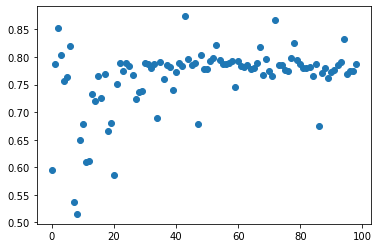

In [5]:
err = sess.trial_info['lick_meanpos'][sess.trial_info['block_number']<5]
start_err = err[:5].mean()
end_err = err[-5:].mean()
print(err)
fig, ax = plt.subplots()
ax.scatter(np.arange(0,err.shape[0]), err)

In [6]:
KO_sessions = {}
for mouse, sessions in stx.ymaze_sess_deets.KO_sessions.items():
    print(sessions)
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    KO_sessions[mouse] = []
    for deets in sessions:
        print(mouse,deets)
        if isinstance(deets,tuple):
            print('tupe')
            sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,_deets['date'], "%s_%d.pkl" % (_deets['scene'],_deets['session'])),verbose = False)
                antic_consum_licks(sess)
                get_probes_and_omissions(sess)
                single_trial_lick_metrics(sess)
                
                sess_list.append({**_deets, **sess.trial_info })
            combined = combine_sessions(sess_list)
            KO_sessions[mouse].append({**combined, 'trial_number': np.arange(combined['LR'].shape[0])})
        else:
            
            sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
            antic_consum_licks(sess)
            get_probes_and_omissions(sess)
            single_trial_lick_metrics(sess)

            KO_sessions[mouse].append({**deets, **sess.trial_info, 'trial_number': np.arange(sess.trial_info['LR'].shape[0]) })
    

            

(({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14}), {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467975.1 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan'

In [7]:
CTRL_sessions = {}
for mouse, sessions in stx.ymaze_sess_deets.CTRL_sessions.items():
    print(sessions)
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    CTRL_sessions[mouse] = []
    for deets in sessions:
        print(mouse,deets)
        if isinstance(deets,tuple):
            print('tupe')
            sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,_deets['date'], "%s_%d.pkl" % (_deets['scene'],_deets['session'])),verbose = False)
                antic_consum_licks(sess)
                get_probes_and_omissions(sess)
                single_trial_lick_metrics(sess)
                
                sess_list.append({**_deets, **sess.trial_info })
            combined = combine_sessions(sess_list)
            CTRL_sessions[mouse].append({**combined, 'trial_number': np.arange(combined['LR'].shape[0])})
#             CTRL_sessions[mouse].append(combine_sessions(sess_list))
        else:
            
            sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
            antic_consum_licks(sess)
            get_probes_and_omissions(sess)
            single_trial_lick_metrics(sess)

#             CTRL_sessions[mouse].append({**deets, **sess.trial_info })
            CTRL_sessions[mouse].append({**deets, **sess.trial_info, 'trial_number': np.arange(sess.trial_info['LR'].shape[0]) })
    


({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}, {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}, {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}), {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 1}, ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467331.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467331.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


4467333.1 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})
tupe
4467333.1 {'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}
4467333.1 ({'date': '08_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '08_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4})
tupe


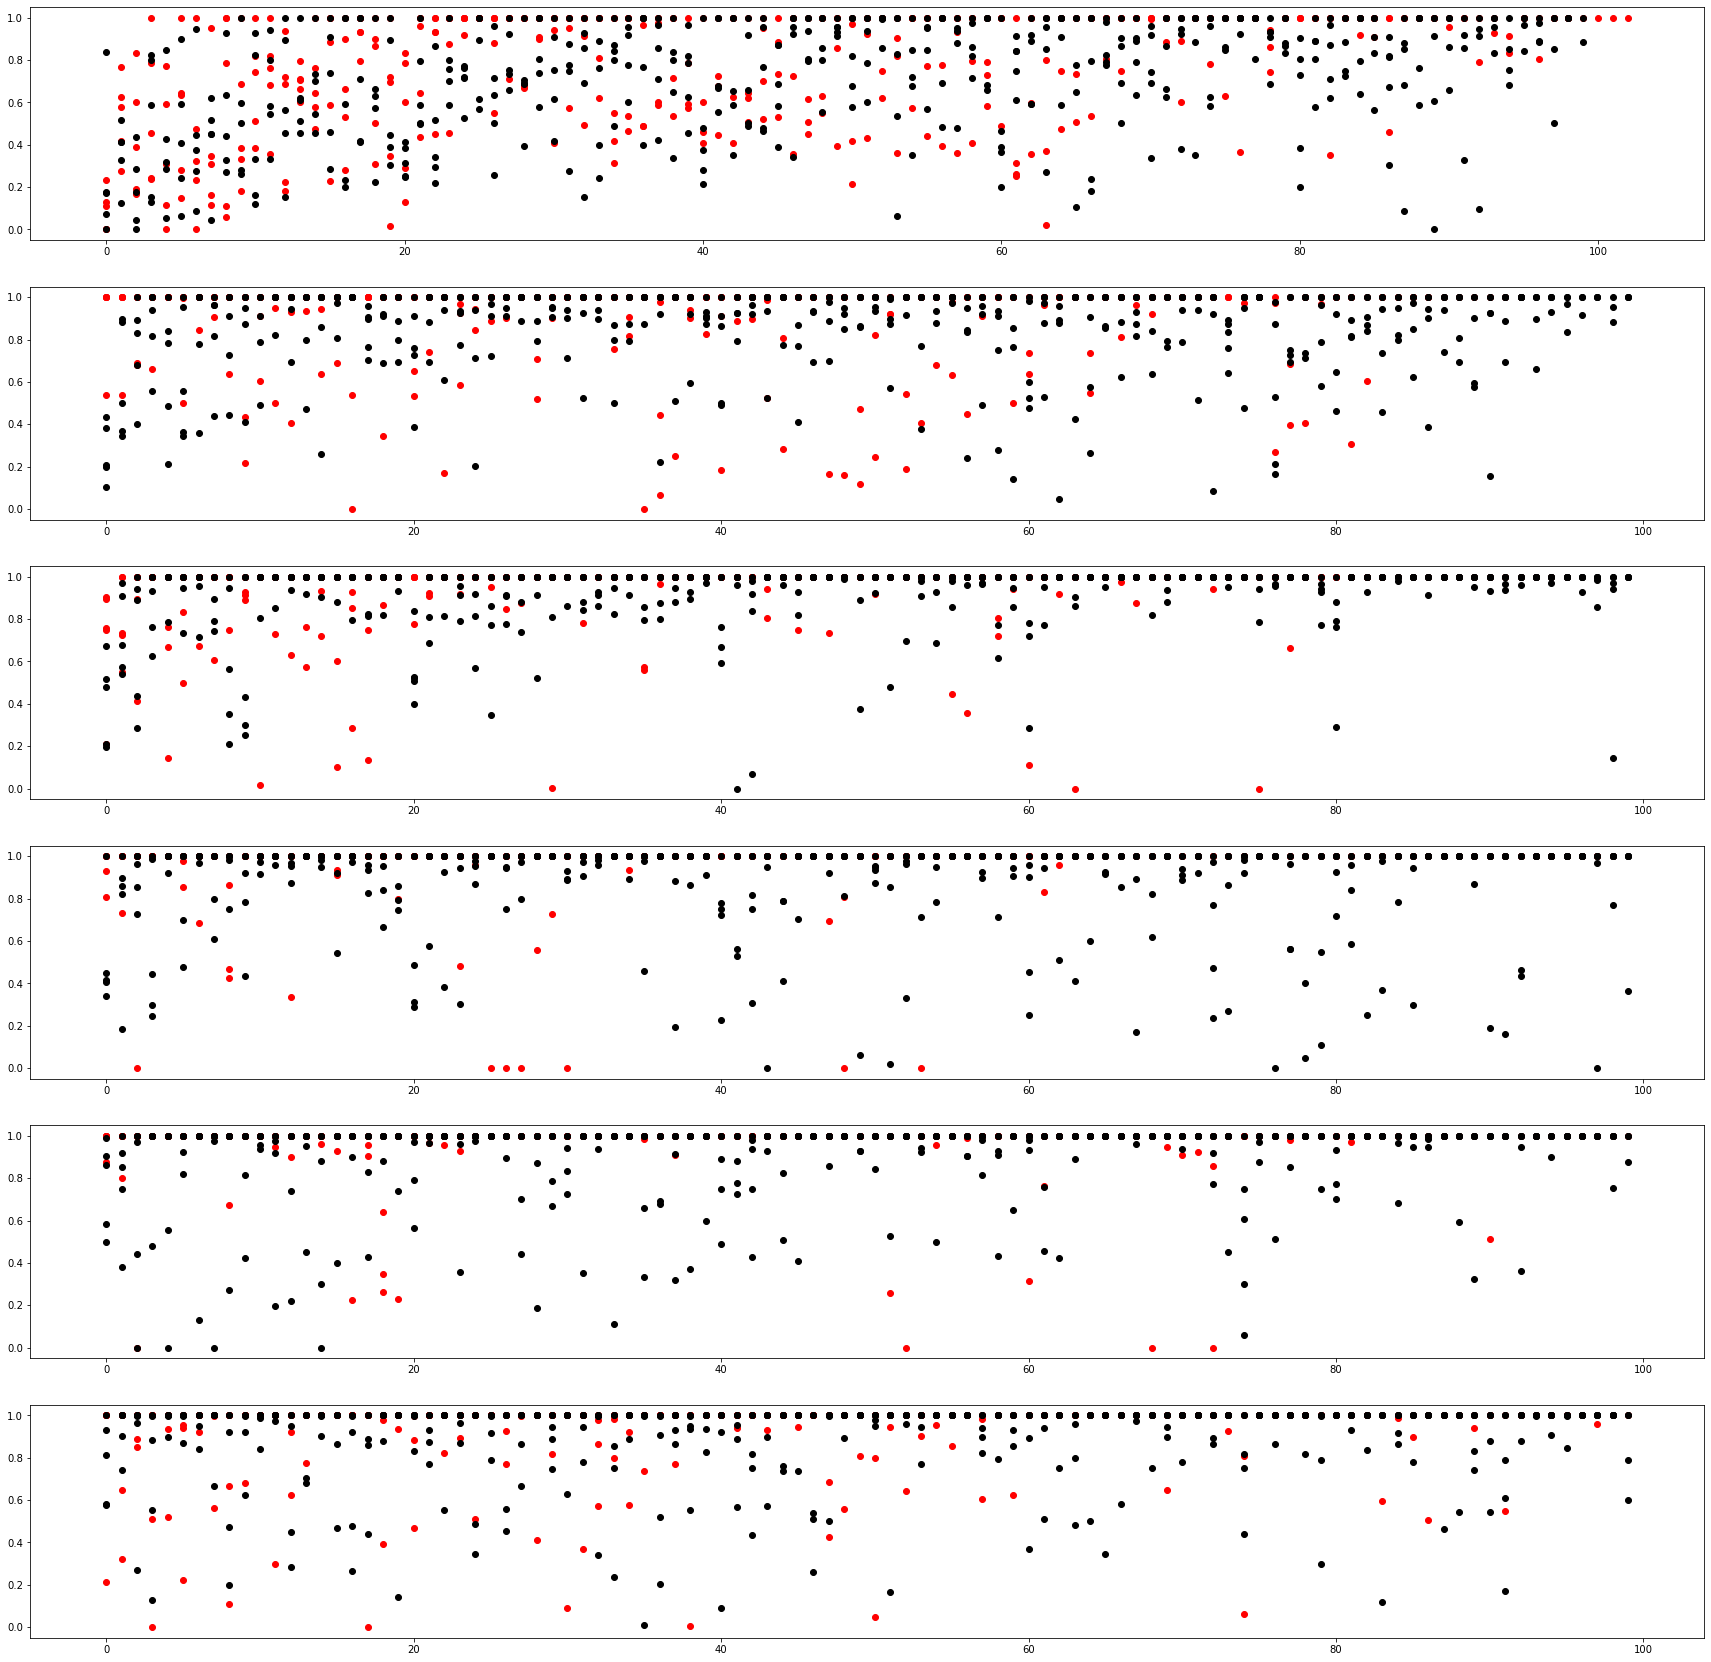

In [8]:
fig,ax = plt.subplots(6,1,figsize=[30,30],sharey=True)

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:6]):
        err = d['lick_acc'][d['block_number']<5]
        
        ax[j].scatter(np.arange(0,err.shape[0]), err,color='red')
        
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:6]):
        err = d['lick_acc'][d['block_number']<5]
        ax[j].scatter(np.arange(0,err.shape[0]), err,color='black')

    

In [9]:
# licking accuracy vs trial for familiar arm on each day
def monoexp_decay_wint(x,a,b,c):
    return a*np.exp(-b*x) + c

def M0(X, a,b,c):
    # # M0 - n params 3
    return a*np.exp(-b*X[0,:]) + c

def M1(X, a0, a1, b,c):
# # M1 - n params 4
# (a0*groupID + a1*(1-groupID))*np.exp(-b*X[:,0])  + c
    return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-b*X[0,:]) + c

def M2(X, a, b0, b1, c):
# #M2 - n params 4
# a*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c
    return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c

def M3(X, a0, a1, b0, b1, c):
# #M3 - n params 5
# (a0*groupID + a1*(1-groupID))*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c
    return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c

def M4(X, a, b, c0, c1):
# #M4 - n params 4
# a*np.exp(-b*X[:,0])  + c0*groupID + c1*(1-groupID)
    return a*np.exp(-b*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def M5(X, a0, a1, b, c0, c1):
# #M5 - n params 5
# (a0*groupID + a1*(1-groupID))*np.exp(-b*X[:,0])  + c0*groupID + c1*(1-groupID) 
    return (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-b*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def M6(X, a, b0, b1, c0, c1):
# #M6 - n params 5
# a*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c0*groupID + c1*(1-groupID)
    return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def M7(X, a0, a1, b0, b1, c0, c1):
# #M7 - n params 6
# (a0*groupID + a1*(1-groupID))*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c0*groupID + c1*(1-groupID)
    return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def sample_std(y,yhat,k):
    return np.sqrt(((y-yhat)**2).sum()/(yhat.shape[0]-k))

def log_likelihood(y, yhat, k):
    sigma = sample_std(y,yhat,k)
    likelihood = sp.stats.norm.pdf(y-yhat,loc=0,scale=sigma)
    log_likelihood = np.log(likelihood).sum()
    return log_likelihood

def bic(y,yhat,k):
    return k*np.log(y.shape[0]) -2.*log_likelihood(y,yhat,k)
    

    

    





<function M0 at 0x7fde826e0670>
<function M0 at 0x7fde826e0670>
<function M0 at 0x7fde826e0670>
<function M7 at 0x7fde5b8de820>
<function M1 at 0x7fde6aa17af0>


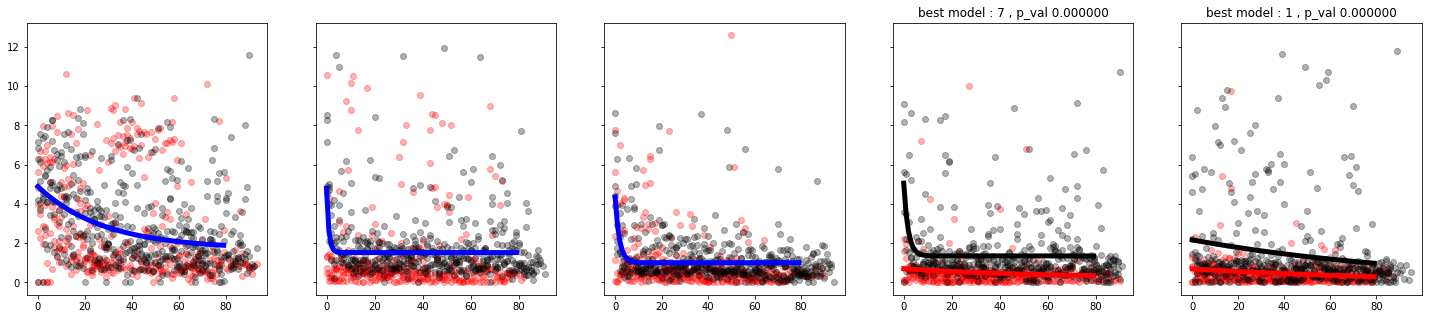

In [57]:
def fit_models(X, acc, crossval = False):
        
        bic_vec = []
        popt_list = []
        SSE = []
        dof = []
        
        # baseline
        popt, pcov = curve_fit(M0, X, acc, maxfev=int(1E5), p0= [2,.05,.75], bounds=(-20,20))
        bic_vec.append(bic(acc,M0(X,*popt),3))
        SSE.append(((acc-M0(X, *popt))**2).mean())
        dof.append(acc.shape[0]-3)
        popt_list.append(popt)
        
        # groupwise intercept
        popt, pcov = curve_fit(M1, X, acc, maxfev=int(1E5), p0= [2,2, .05,.75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M1(X,*popt),5))
        SSE.append(((acc-M1(X, *popt))**2).mean())
        dof.append(acc.shape[0]-5)
        popt_list.append(popt)
        
        # groupwise slope
        popt, pcov = curve_fit(M2, X, acc, maxfev=int(1E5), p0= [2,.05,.05,.75], bounds=(-20,20))
        
        bic_vec.append(bic(acc,M2(X,*popt),5))
        SSE.append(((acc-M2(X, *popt))**2).mean())
        dof.append(acc.shape[0]-5)
        popt_list.append(popt)
       
        # groupwise slope and intercept
        popt, pcov = curve_fit(M3, X, acc, maxfev=int(1E5), p0= [2,2, .05, .05,.75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M3(X,*popt),6))
        SSE.append(((acc-M3(X, *popt))**2).mean())
        dof.append(acc.shape[0]-6)
        popt_list.append(popt)
        
        # groupwise asymptote
        popt, pcov = curve_fit(M4, X, acc, maxfev=int(1E5), p0= [2,.05,.75, .75], bounds=(-20,20))
        
        bic_vec.append(bic(acc,M4(X,*popt),5))
        SSE.append(((acc-M4(X, *popt))**2).mean())
        dof.append(acc.shape[0]-5)
        popt_list.append(popt)
        
        # groupwise intercept and asymptote
        popt, pcov = curve_fit(M5, X, acc, maxfev=int(1E5), p0= [2,2, .05,.75, .75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M5(X,*popt),6))
        SSE.append(((acc-M5(X, *popt))**2).mean())
        dof.append(acc.shape[0]-6)
        popt_list.append(popt)
        
        # groupwise slope and asymptote
        popt, pcov = curve_fit(M6, X, acc, maxfev=int(1E5), p0= [2,2, .05,.75, .75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M6(X,*popt),6))
        SSE.append(((acc-M6(X, *popt))**2).mean())
        dof.append(acc.shape[0]-6)
        popt_list.append(popt)
        
        # groupwise intercept, slope, and asymptote
        popt, pcov = curve_fit(M7, X, acc, maxfev=int(1E5), p0= [2,2, .05, .05,.75, .75], bounds=(-20,20))
        
        bic_vec.append(bic(acc,M7(X,*popt),7))
        SSE.append(((acc-M7(X, *popt))**2).sum())
        dof.append(acc.shape[0]-7)
        popt_list.append(popt)
        
        bic_vec = np.array(bic_vec) - bic_vec[0]
        
        
        if crossval:
            kf = KFold(n_splits = 10, shuffle=True)
            SSE_cv = np.zeros([10,bic_vec.shape[0]])
            for fold, (train,test) in enumerate(kf.split(X.T)):
                X_train, acc_train = X[:,train], acc[train]
                X_test, acc_test = X[:,test], acc[test]
                
                
                # baseline
                popt, pcov = curve_fit(M0, X_train, acc_train, maxfev=int(1E5), p0= [2,.05,.75], bounds=(-20,20))
#                 SSE_cv[fold, 0 ]=((acc_test-M0(X_test, *popt))**2).mean()
                SSE_cv[fold, 0] = log_likelihood(acc, M0(X, *popt), 1).sum()

                # groupwise intercept
                popt, pcov = curve_fit(M1, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05,.75], bounds=(-20,20))
#                 SSE_cv[fold, 1 ]=((acc_test-M1(X_test, *popt))**2).mean()
                SSE_cv[fold, 1] = log_likelihood(acc, M1(X, *popt), 1).sum()
                # groupwise slope
                popt, pcov = curve_fit(M2, X_train, acc_train, maxfev=int(1E5), p0= [2,.05,.05,.75], bounds=(-20,20))
#                 SSE_cv[fold, 2 ]=((acc_test-M2(X_test, *popt))**2).mean()
                SSE_cv[fold, 2] = log_likelihood(acc, M2(X, *popt), 1).sum()
                # groupwise slope and intercept
                popt, pcov = curve_fit(M3, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05, .05,.75], bounds=(-20,20))
#                 SSE_cv[fold, 3 ]=((acc_test-M3(X_test, *popt))**2).mean()
                SSE_cv[fold, 3] = log_likelihood(acc, M3(X, *popt), 1).sum()
                # groupwise asymptote
                popt, pcov = curve_fit(M4, X_train, acc_train, maxfev=int(1E5), p0= [2,.05,.75, .75], bounds=(-20,20))
#                 SSE_cv[fold, 4 ]=((acc_test-M4(X_test, *popt))**2).mean()
                SSE_cv[fold, 4] = log_likelihood(acc, M4(X, *popt), 1).sum()
                # groupwise intercept and asymptote
                popt, pcov = curve_fit(M5, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05,.75, .75], bounds=(-20,20))
#                 SSE_cv[fold, 5 ]=((acc_test-M5(X_test, *popt))**2).mean()
                SSE_cv[fold, 5] = log_likelihood(acc, M5(X, *popt), 1).sum()
                # groupwise slope and asymptote
                popt, pcov = curve_fit(M6, X_train, acc_train, maxfev=int(1E5), p0= [2,.05, .05,.75, .75], bounds=(-20,20))
#                 SSE_cv[fold, 6 ]=((acc_test-M6(X_test, *popt))**2).mean()
                SSE_cv[fold, 6] = log_likelihood(acc, M6(X, *popt), 1).sum()
                # groupwise intercept, slope, and asymptote
                popt, pcov = curve_fit(M7, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05, .05,.75, .75], bounds=(-20,20))
#                 SSE_cv[fold, 7 ]=((acc_test-M7(X_test, *popt))**2).mean()
                SSE_cv[fold, 7] = log_likelihood(acc, M7(X, *popt), 1).sum()
              
              
                
            return bic_vec, np.array(SSE), np.array(dof), popt_list, SSE_cv.sum(axis=0)
        else:
        
            return bic_vec, np.array(SSE), np.array(dof), popt_list

def run_model_comparisons(KO_sessions,CTRL_sessions,metric):
    
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]
    
    perms = generate_perms(ko_mice,ctrl_mice)
    all_sessions = {**KO_sessions, **CTRL_sessions}
    
    results = []
    fig,ax = plt.subplots()
    for day in range(5):
        
        X = []
        acc = []
        for mouse, d_list in KO_sessions.items():
            d = d_list[day]
            _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
            
            trials = np.arange(_acc.shape[0])
            if mouse=='4467975.4' and day==0:
                mask = np.ones(_acc.shape)>0
                mask[24-5:68-5] = False
                _acc = _acc[mask]
                trials = trials[mask]
            
            acc.append(_acc)
            _x = np.zeros([2,trials.shape[0]])
            _x[0,:] = trials
            
            X.append(_x)
            
        for mouse, d_list in CTRL_sessions.items():
            d = d_list[day]
            _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
            acc.append(_acc)
            trials = np.arange(_acc.shape[0])
            _x = np.ones([2,trials.shape[0]])
            _x[0,:] = trials
            
            X.append(_x)
    
        acc = np.concatenate(acc, axis=-1)
#         print(acc.shape)
        X = np.concatenate(X,axis=-1)
        
        random_order = np.random.permutation(int(acc.shape[0]))
        X = X[:,random_order]
        acc = acc[random_order]
#         print(random_order)
        
        
        print(acc.shape,X.shape)
        
        bic_vec, SSE, dof, popt_list, SSE_cv = fit_models(X, acc, crossval=True)
        print(SSE_cv)
       
        
#         F = lambda SSE_red, dof_red, SSE_full, dof_full: ((SSE_red-SSE_full)/(dof_red  - dof_full))/(SSE_full/dof_full)
#         f_stats = [0, 
#                    F(SSE[0],dof[0],SSE[1],dof[1]), # M1
#                    F(SSE[0],dof[0],SSE[2],dof[2]), # M2
#                    F(SSE[1],dof[1],SSE[3],dof[3]), # M3 - compare to intercept only
#                    F(SSE[0],dof[0],SSE[4],dof[4]), # M4
#                    F(SSE[1],dof[1],SSE[5],dof[5]), # M5 - compare to intercept only
#                    F(SSE[2],dof[2],SSE[6],dof[6]), # M6 - compare to slope only
#                    F(SSE[5],dof[5],SSE[7],dof[7]), # M7
#                   ]
        
#         p_vec = [1, 
#                  1-sp.stats.f.cdf(f_stats[1],dof[0],dof[1]), # M1
#                  1-sp.stats.f.cdf(f_stats[2],dof[0],dof[2]), # M2
#                  1-sp.stats.f.cdf(f_stats[3],dof[1],dof[3]), # M3
#                  1-sp.stats.f.cdf(f_stats[4],dof[0],dof[4]), # M4
#                  1-sp.stats.f.cdf(f_stats[5],dof[1],dof[5]), # M1
#                  1-sp.stats.f.cdf(f_stats[6],dof[2],dof[6]), # M1
#                  1-sp.stats.f.cdf(f_stats[7],dof[5],dof[7]), # M1
#                 ]
#         for i, (_f, _p) in enumerate(zip(f_stats,p_vec)):
#             print('M%d F-stat %f p %f' % (i, _f, _p))
                   
        
        ax.plot(bic_vec,color=plt.cm.magma(day/4.))
        print('min bic', np.argmin(bic_vec), 'min bic val', np.amin(bic_vec)-bic_vec[0])
        
        perm_SSE = []
        for p, (l0,l1) in enumerate(perms):
            
            X = []
            acc = []
            
            for mouse, d_list in {mouse:all_sessions[mouse] for mouse in l0}.items():
                d = d_list[day]
                _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
                trials = np.arange(_acc.shape[0])
                
                
                if mouse=='4467975.4' and day==0:
                    mask = np.ones(_acc.shape)>0
                    mask[24-5:68-5] = False
                    _acc = _acc[mask]
                    trials = trials[mask]
                
                acc.append(_acc)
                
                _x = np.zeros([2,trials.shape[0]])
                _x[0,:] = trials

                X.append(_x)

            for mouse, d_list in {mouse:all_sessions[mouse] for mouse in l1}.items():
                d = d_list[day]
                _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
                trials = np.arange(_acc.shape[0])
                if mouse=='4467975.4' and day==0:
                    mask = np.ones(_acc.shape)>0
                    mask[24-5:68-5] = False
                    _acc = _acc[mask]
                    trials = trials[mask]

                acc.append(_acc)
                _x = np.ones([2,trials.shape[0]])
                _x[0,:] = trials

                X.append(_x)
            
            acc = np.concatenate(acc, axis=-1)
            X = np.concatenate(X,axis=-1)
            random_order = np.random.permutation(int(acc.shape[0]))
            X = X[:,random_order]
            acc = acc[random_order]
            
            _bic_vec, _SSE, _dof, _popt_list, _SSE_cv = fit_models(X, acc, crossval=True)
            perm_SSE.append(_SSE_cv)
            
        print(np.array(perm_SSE).shape)
        perm_SSE = np.array(perm_SSE)
        pvec = []
        for col in range(perm_SSE.shape[1]):
            print("Day %d" % day)
            true_SSE = SSE_cv[col]
            _perm_SSE = perm_SSE[:,col]
            p_val = np.float((true_SSE+1E-3<_perm_SSE).sum())/_perm_SSE.shape[0]
            print("M%d, true SSE %f, lowest perm SSE %f, 'p' value %f" % (col, true_SSE, np.amax(_perm_SSE),p_val))
            pvec.append(p_val)
            
            
        results.append({'bic_vec': bic_vec, 'popt_list': popt_list, 'LL_cv': SSE_cv, 'p_val':pvec})
        
    return results
    



def plot_fam_acc(results, metric):
    fig,ax = plt.subplots(1,5,figsize=[25,5], sharey=True)
    for day in range(5):
        
        for mouse, d_list in KO_sessions.items():
            d = d_list[day]
            acc = d[metric][(d['block_number']<5)*(d['probes']==0)]
            trials = np.arange(acc.shape[0])
            
            ax[day].scatter(trials,acc,alpha=.3, color='red')
            
        for mouse, d_list in CTRL_sessions.items():
            d = d_list[day]
            acc = d[metric][(d['block_number']<5)*(d['probes']==0)]
            trials = np.arange(acc.shape[0])
            
            ax[day].scatter(trials,acc,alpha=.3, color='black')
            
            
        LL_cv = results[day]['LL_cv']
        pval = np.array(results[day]['p_val'])
#         ax[day].plot(LL_cv)
        if True:
            # first stage 
            # M0 baseline model
            # M1 groupwise intercept
            # M2 groupwise slope
            # M3 groupwise slope and intercept
            # M4 groupwise asymptote
            # M5 groupwise intercept and asymptote
            # M6 groupwise slope and asymptote
            # M7 groupwise intercept, slope, and asymptote

            onep_inds = [1,2,4]
            onep_LLR = LL_cv[onep_inds] - LL_cv[0]
            onep_pval = pval[onep_inds]

            best_onep_ind = np.argmax(onep_LLR)
            if (onep_pval[best_onep_ind]<.01) and onep_LLR[best_onep_ind]>5:

                if best_onep_ind == 0:
                    twop_inds = [3,5]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[0]]
                    twop_pval = pval[twop_inds]


                elif best_onep_ind == 1:
                    twop_inds = [3,6]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[1]]
                    twop_pval = pval[twop_inds]
                elif best_onep_ind == 2:
                    twop_inds = [5,6]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[2]]
                    twop_pval = pval[twop_inds]
                else:
                    print("onep fail")

                best_twop_ind = np.argmax(twop_LLR)
                if (twop_LLR[best_twop_ind]>5) and (twop_pval[best_twop_ind]<.01):
                    
                    threep_LLR = LL_cv[-1] - LL_cv[twop_inds[best_twop_ind]]
                    if (threep_LLR>5) and (pval[-1]<.05):
                        bestmodel = 7
                    else:
                        bestmodel = twop_inds[best_twop_ind]
                    
                else:
                    bestmodel = onep_inds[best_onep_ind]

            else:
                bestmodel = 0

            X = np.zeros([2,80])
            X[0,:] = np.arange(80)
#             bic_vec = results[day]['bic_vec']
#     #         bic_vec -= bic_vec[0]
#             min_bic, argmin_bic = np.amin(bic_vec), np.argmin(bic_vec)

#             if min_bic<=-10:
#                 bestmodel = argmin_bic
#             else:
#                 bestmodel = 0

#             print(min_bic,bestmodel)
    #         bestmodel = np.argmin(results[day]['bic_vec'])
            if bestmodel ==0:
                M = M0
            elif bestmodel ==1:
                M = M1
            elif bestmodel ==2:
                M=M2
            elif bestmodel ==3:
                M=M3
            elif bestmodel ==4:
                M=M4
            elif  bestmodel ==5:
                M=M5
            elif bestmodel ==6:
                M=M6
            else:
                M=M7
            print(M)


            if not bestmodel==0:

                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='red',linewidth=5)

                X[1,:] = 1
                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='black',linewidth=5)

                ax[day].set_title("best model : %d , p_val %f" % (bestmodel, results[day]['p_val'][bestmodel]))
            else:
                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='blue',linewidth=5)

        

# results = run_model_comparisons(KO_sessions,CTRL_sessions, 'lick_varpos')
plot_fam_acc(results, 'lick_varpos')


# change accuracy to squared distance to front of reward zone

# fit models with same or different parameters and calculate AIC, assuming identical variance

# fit exponentioal 


In [ ]:
def single_day_pool_acc(sessions,day_ind, fam = None):
    fam_acc, fam_inds, nov_acc, nov_inds = [],[], [], []
    for mouse,d_list in sessions.items():
        
        d=d_list[day_ind]
#         print(d['lick_err'])
        if fam is None:
            fam = d['LR'][0]
        fam_trials = d['lick_acc'][d['LR']==fam]
        fam_inds.append(np.arange(fam_trials.shape[0]))
        fam_acc.append(fam_trials)
        nov_trials= d['lick_acc'][d['LR']==-1.*fam]
        nov_inds.append(np.arange(nov_trials.shape[0]))
        nov_acc.append(nov_trials)
    return np.concatenate(fam_inds), np.concatenate(fam_acc), np.concatenate(nov_inds), np.concatenate(nov_acc)

def run_fam_acc(KO_sessions,CTRL_sessions):
    
    
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]
    all_sessions = {**KO_sessions, **CTRL_sessions}
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    for day in range(5):
        ko_fam_trials, ko_fam_acc, _, _ = single_day_pool_acc(KO_sessions,day)
        ctrl_fam_trials, ctrl_fam_acc, _, _ = single_day_pool_acc(CTRL_sessions,day)
        all_fam_trials, all_fam_acc, _, _ = single_day_pool_acc(all_sessions,day)
        
        ko_popt, ko_pcov = curve_fit(monoexp_decay_wint, ko_fam_trials, ko_fam_acc, maxfev=int(1E5), method='trf', loss='huber')
       
        ctrl_popt, ctrl_pcov = curve_fit(monoexp_decay_wint, ctrl_fam_trials, ctrl_fam_acc, maxfev=int(1E5), method='trf', loss='huber')
       
        all_popt, all_pcov = curve_fit(monoexp_decay_wint, all_fam_trials, all_fam_acc, maxfev=int(1E5), method='trf', loss='huber')
    
        true_diff = np.abs(ko_popt-ctrl_popt)
        perm_diff = []
        for (l0,l1) in perms:
            l0_inds, l0_acc, _, _ = single_day_pool_acc({m:all_sessions[m] for m in l0},day)
            l1_inds, l1_acc, _, _ = single_day_pool_acc({m:all_sessions[m] for m in l1},day)
            
            l0_popt, l0_pcov = curve_fit(monoexp_decay_wint, l0_inds, l0_acc, maxfev=int(1E5), method='trf', loss='huber')
            l1_popt, k1_pcov = curve_fit(monoexp_decay_wint, l1_inds, l1_acc, maxfev=int(1E5), method='trf', loss='huber')
            perm_diff.append(np.abs(ko_popt-ctrl_popt))
        
        perm_diff = np.array(perm_diff)
        print('values',ko_popt,ctrl_popt)
        print('p_values', [1-np.float((true_diff[i]>=perm_diff[:,i]).sum())/perm_diff.shape[0] for i in range(true_diff.shape[0])])
        


        fig,ax = plt.subplots()
        ax.scatter(ko_fam_trials,ko_fam_acc,color='red',alpha=.3)
        ax.scatter(ctrl_fam_trials,ctrl_fam_acc,color='black',alpha=.3)


        t = np.linspace(0,100)
    
        ax.plot(t, monoexp_decay_wint(t, *ko_popt), color='red',linewidth=5)
        ax.plot(t, monoexp_decay_wint(t, *ctrl_popt), color='black',linewidth=5)
    
    
#     ax[1].scatter(KO_concat_lrs['late_rz_inds'],KO_concat_lrs['late_rz_lr'],color='red',alpha=.3)
#     ax[1].scatter(CTRL_concat_lrs['late_rz_inds'],CTRL_concat_lrs['late_rz_lr'],color='black',alpha=.3)
    
#     ax[1].plot(t, monoexp_decay(t, *KO_late_popt), color='red',linewidth=5)
#     ax[1].plot(t, monoexp_decay(t, *CTRL_late_popt), color='black',linewidth=5)
    
#     ax[0].spines['top'].set_visible(False)
#     ax[0].spines['right'].set_visible(False)
    
#     ax[1].spines['top'].set_visible(False)
#     ax[1].spines['right'].set_visible(False)
    
#     ax[0].set_ylabel('Lick Rate (norm.)')
#     ax[0].set_xlabel('Repetition/Trial')
#     fig.suptitle('Previous Reward Zone Licking')
#     ax[0].set_title('Left Trials')
    
#     ax[1].set_xlabel('Repetition/Trial')
#     ax[1].set_ylabel('Lick Rate(norm)')
#     ax[1].set_title('Right Trials')
#     return fig, ax
    
    
run_fam_acc(KO_sessions,CTRL_sessions)

#look at drop in aic for real sorting vs others


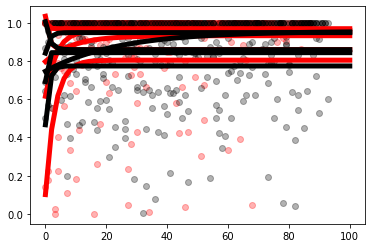

In [129]:
# licking accuracy vs trial for familiar arm on each day
def monoexp_decay_wint(x,a,b,c):
    return a*np.exp(-b*x) + c




ko_mice = [k for k in KO_sessions.keys()]
ctrl_mice = [k for k in CTRL_sessions.keys()]
all_sessions = {**KO_sessions, **CTRL_sessions}

perms = generate_perms(ko_mice,ctrl_mice)
fig,ax = plt.subplots()
ko_popt = []
ctrl_popt=[]
for day in range(5,6):
    
    for mouse, d_list in KO_sessions.items():
        
        d = d_list[day]
        err = d['lick_acc'][(d['block_number']<5)*(d['probes']==0)][:]     
        trials = np.arange(err.shape[0])
        
        if mouse=='4467975.4' and day==0:
            mask = np.ones(err.shape)>0
            mask[24-5:68-5] = False
            err = err[mask]
            trials = trials[mask]
            
        popt,pcov = curve_fit(monoexp_decay_wint,trials, err, maxfev= int(1E5), method='trf', loss='huber')
        ko_popt.append(popt)
        ax.scatter(trials,err,color='red',alpha=.3)
        t = np.linspace(0,100)
        ax.plot(t, monoexp_decay_wint(t, *popt), color='red',linewidth=5)
    
    for mouse, d_list in CTRL_sessions.items():
        d = d_list[day]
        err = d['lick_acc'][(d['block_number']<5)*(d['probes']==0)][:]
        trials = np.arange(err.shape[0])
        
        popt,pcov = curve_fit(monoexp_decay_wint,trials, err, maxfev= int(1E5), method='trf', loss='huber')
        ctrl_popt.append(popt)
        ax.scatter(trials,err,color='black',alpha=.3)
        t = np.linspace(0,100)
        ax.plot(t, monoexp_decay_wint(t, *popt), color='black',linewidth=5)
ko_popt = np.array(ko_popt)
ctrl_popt = np.array(ctrl_popt)

[[ 0.03455857  1.44450711  0.96947104]
 [-0.34473201  0.28830369  0.96058072]
 [-0.70357934  0.32561347  0.80477598]
 [-0.13560857  0.11270642  0.93289216]
 [ 0.17444915  0.86754546  0.86020975]]
[[-0.15183399 16.91927577  0.84408847]
 [-0.30769325  0.88825329  0.77430095]
 [-0.10740836  0.8444393   0.94904713]
 [-0.20928183  0.04185018  0.9558945 ]
 [ 0.14625126  0.72953361  0.85974217]]
Ttest_indResult(statistic=-0.40205526036124684, pvalue=0.6981711489939525)
Ttest_indResult(statistic=-1.0016970862625985, pvalue=0.3458216231425697)
Ttest_indResult(statistic=0.6218138985707674, pvalue=0.5513689013687428)
Ttest_indResult(statistic=-0.6028996195750771, pvalue=0.5632721931532452)


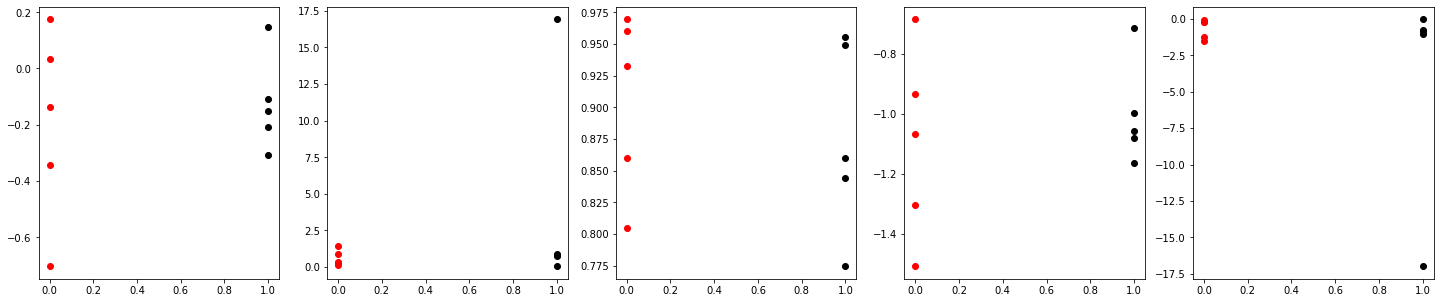

In [130]:
print(np.array(ko_popt))
print(np.array(ctrl_popt))

print(sp.stats.ttest_ind(ko_popt[:,0],ctrl_popt[:,0]))
print(sp.stats.ttest_ind(ko_popt[:,1],ctrl_popt[:,1]))
print(sp.stats.ttest_ind(ko_popt[:,2],ctrl_popt[:,2]))
print(sp.stats.ttest_ind(ko_popt[:,0]-ko_popt[:,2],ctrl_popt[:,0]-ctrl_popt[:,2]))

fig,ax = plt.subplots(1,5,figsize=[25,5])
zeros = np.zeros([5,])
ones = np.ones([5,])
ax[0].scatter(zeros,ko_popt[:,0],color='red')
ax[0].scatter(ones,ctrl_popt[:,0],color='black')

ax[1].scatter(zeros,ko_popt[:,1],color='red')
ax[1].scatter(ones,ctrl_popt[:,1],color='black')

ax[2].scatter(zeros,ko_popt[:,2],color='red')
ax[2].scatter(ones,ctrl_popt[:,2],color='black')

ax[3].scatter(zeros,ko_popt[:,0]-ko_popt[:,2],color='red')
ax[3].scatter(ones,ctrl_popt[:,0]-ctrl_popt[:,2],color='black')

ax[4].scatter(zeros,ko_popt[:,1]/(ko_popt[:,0]-ko_popt[:,2]),color='red')
ax[4].scatter(ones,ctrl_popt[:,1]/(ctrl_popt[:,0]-ctrl_popt[:,2]),color='black')

In [ ]:
# licking accuracy for novel arm

In [ ]:
# running behavior for novel arm

In [8]:
KO_sessions['4467975.1'][0].keys()

dict_keys(['date', 'scene', 'session', 'scan', 'block_number', 'LR', 'probes', 'omissions', 'lickrate_rz_early', 'lickrate_rz_late', 'lickrate_dprime', 'lick_acc', 'lick_meanpos', 'lick_varpos', 'trial_number'])

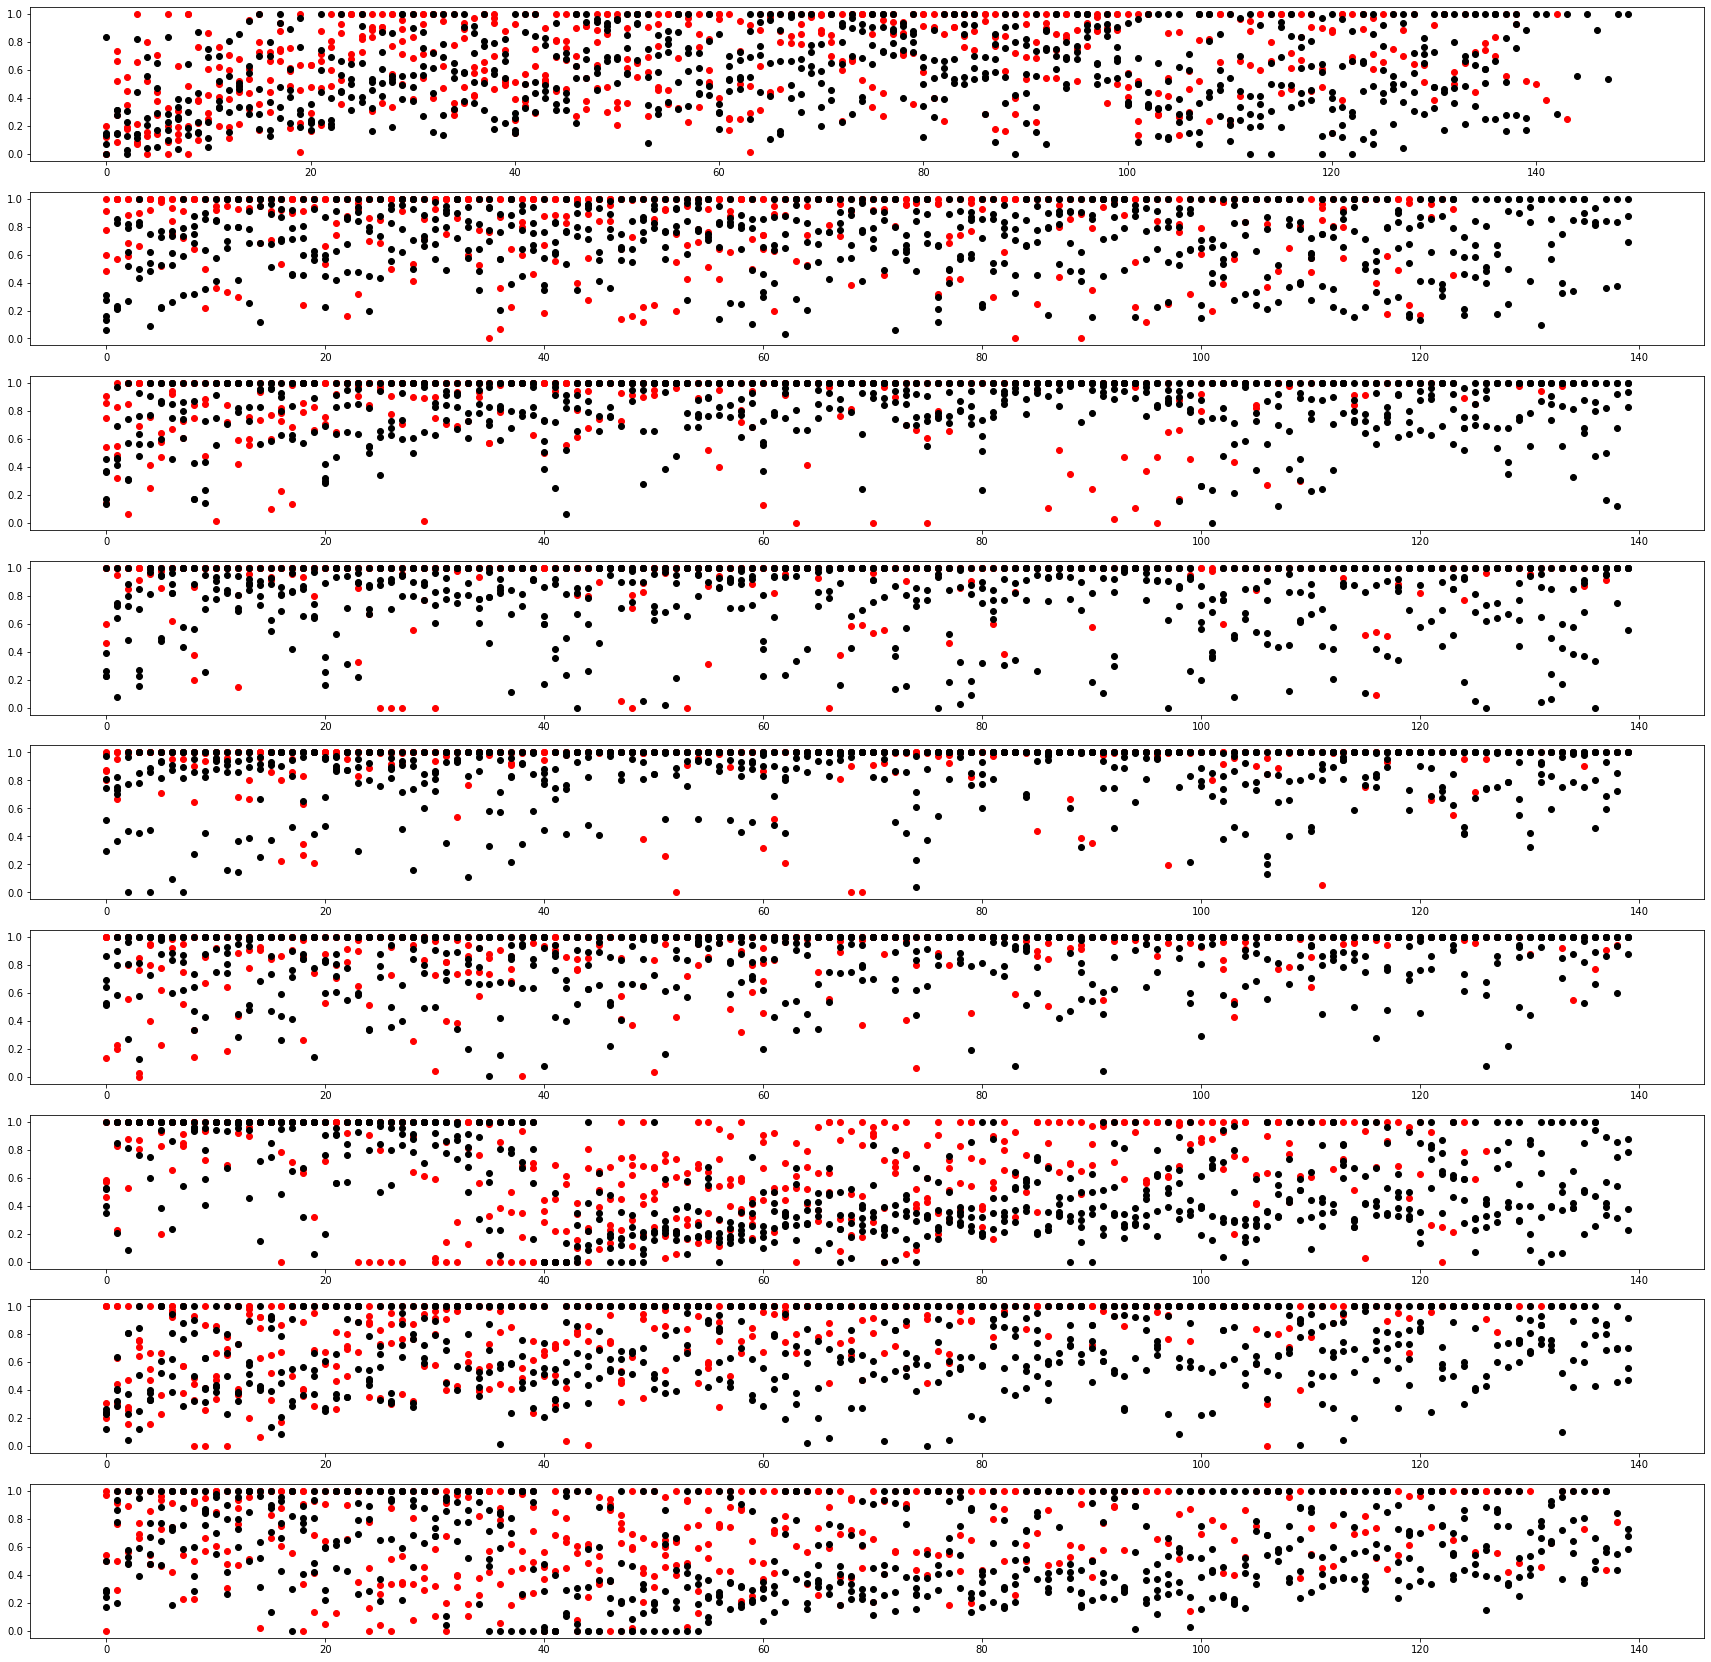

In [46]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
#         ax[j].scatter(d['trial_number'][d['probes']==0],d['lick_varpos'][d['probes']==0], color = 'red')
        ax[j].scatter(d['trial_number'],d['lick_acc'], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
#         ax[j].scatter(d['trial_number'][d['probes']==0],d['lick_varpos'][d['probes']==0], color = 'black')
        ax[j].scatter(d['trial_number'],d['lick_acc'], color = 'black')
    



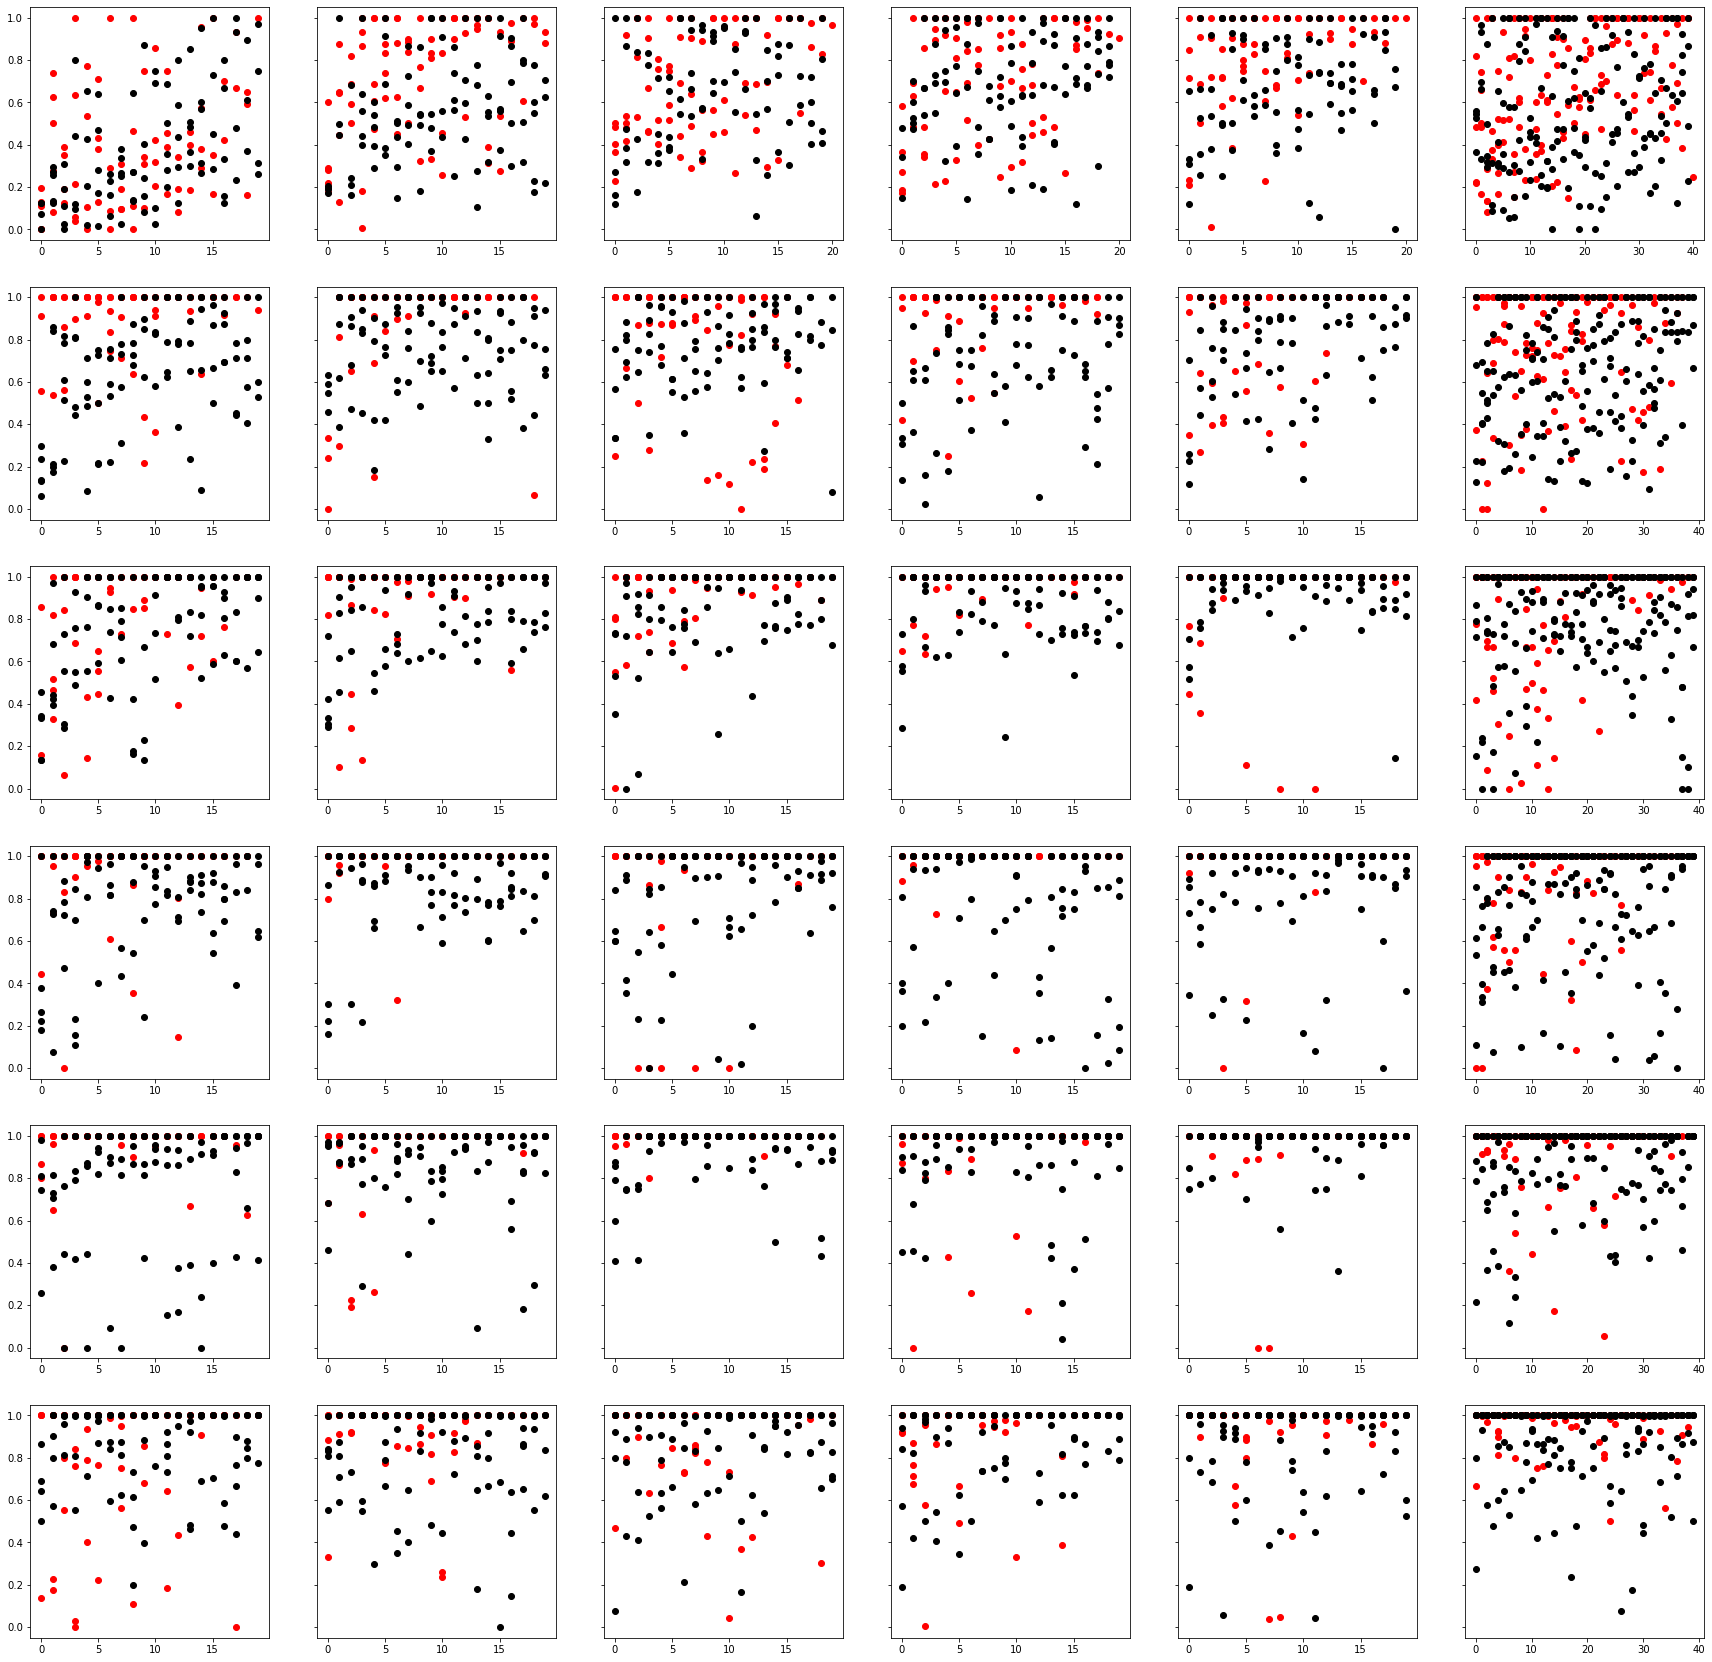

In [103]:
fig,ax = plt.subplots(6,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:6]):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = d['lick_acc'][block_mask]
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:6]):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = d['lick_acc'][block_mask]
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])
    

0.0016666666666666668


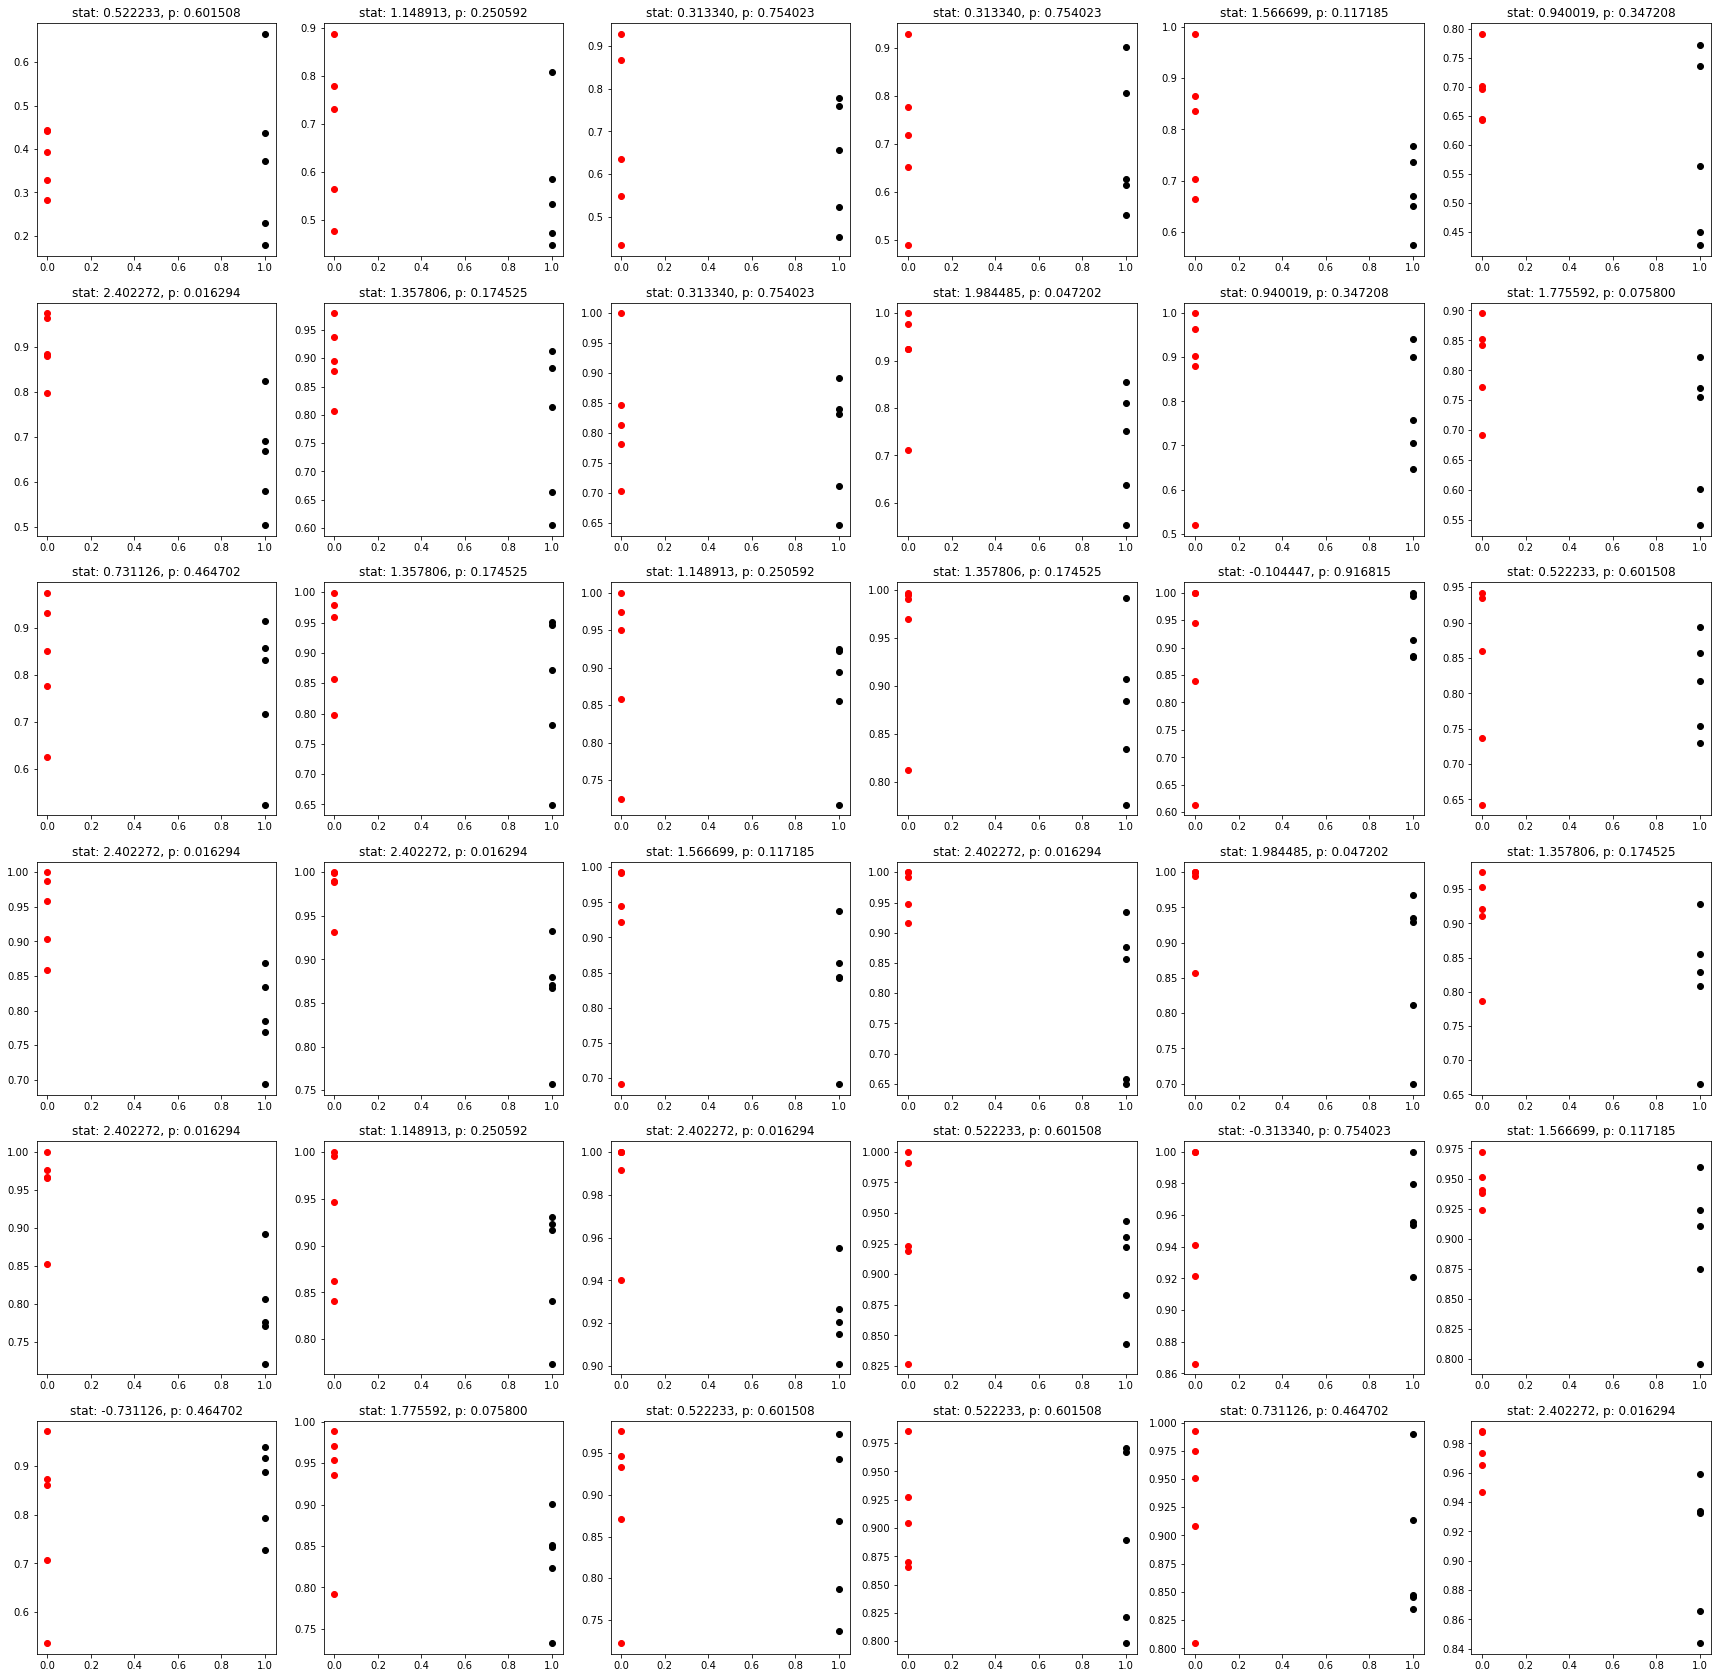

In [105]:
fig,ax = plt.subplots(6,6,figsize=[30,30])
print(.05/30)
for row in range(6):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
        stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
#         stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

In [49]:
stat,p = sp.stats.ttest_ind(KO_vars.mean(axis=-1).mean(axis=-1).ravel() ,CTRL_vars.mean(axis=-1).mean(axis=-1).ravel())
print(stat,p)

2.16264835059678 0.06253082209562447


40
4467331.1 17
40
4467331.2 17
40
4467332.1 19
40
4467332.2 18
40
4467333.1 18


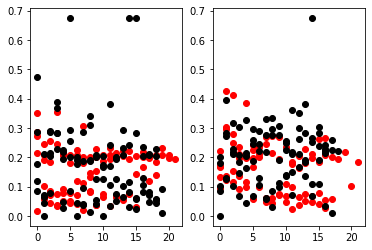

In [98]:
# day 1 novel arm test
fig,ax = plt.subplots(1,2)
KO_vars = np.zeros([5,2])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[0]
#     for j,d in enumerate(d_list[:6]):
    block = 5
    block_mask = d['block_number']==block

    lick_varpos = d['lick_err'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]

    fam_mask = (lr==fam_arm) #& (probes==0)
    
    nov_mask = (lr==nov_arm)# & (probes==0)
    ax[0].scatter(np.arange(fam_mask.sum()),lick_varpos[fam_mask],color='red')
    ax[1].scatter(np.arange(nov_mask.sum()),lick_varpos[nov_mask],color='red')

    fam_var = lick_varpos[(lr==fam_arm) & (probes==0)]
    KO_vars[i,0] = np.nanmean(fam_var)
    nov_var = lick_varpos[(lr==nov_arm) & (probes==0)]
    KO_vars[i,1] = np.nanmean(nov_var)
        
CTRL_vars = np.zeros([5,2])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[0]
#     for j,d in enumerate(d_list[:6]):
    if mouse == '4467332.2':
        block=6
    else:
        block = 5
    block_mask = d['block_number']==block
    print(block_mask.sum())

    lick_varpos = d['lick_err'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]

    fam_mask = (lr==fam_arm) & (probes==0)
    nov_mask = (lr==nov_arm) & (probes==0)
    print(mouse,nov_mask.sum())
    ax[0].scatter(np.arange(fam_mask.sum()),lick_varpos[fam_mask],color='black')
    ax[1].scatter(np.arange(nov_mask.sum()),lick_varpos[nov_mask],color='black')

    fam_var = lick_varpos[(lr==fam_arm) & (probes==0)]
    CTRL_vars[i,0] = np.nanmean(fam_var)
    nov_var = lick_varpos[(lr==nov_arm) & (probes==0)]
    CTRL_vars[i,1] = np.nanmean(nov_var)
        

Text(0.5, 1.0, 'stat: 1.132513, p: 0.290219')

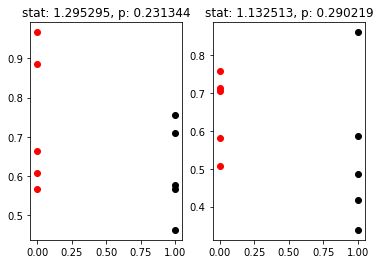

In [60]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(np.zeros([5,]), KO_vars[:,0],color='red')
ax[0].scatter(np.ones([5,]), CTRL_vars[:,0],color='black')
# stat,p = sp.stats.ranksums(KO_vars[:,0].ravel() ,CTRL_vars[:,0].ravel())
stat,p = sp.stats.ttest_ind(KO_vars[:,0].ravel() ,CTRL_vars[:,0].ravel())
ax[0].set_title("stat: %f, p: %f" % (stat,p))

ax[1].scatter(np.zeros([5,]), KO_vars[:,1],color='red')
ax[1].scatter(np.ones([5,]), CTRL_vars[:,1],color='black')
# stat,p = sp.stats.ranksums(KO_vars[:,1].ravel() ,CTRL_vars[:,1].ravel())
stat,p = sp.stats.ttest_ind(KO_vars[:,1].ravel() ,CTRL_vars[:,1].ravel())
ax[1].set_title("stat: %f, p: %f" % (stat,p))

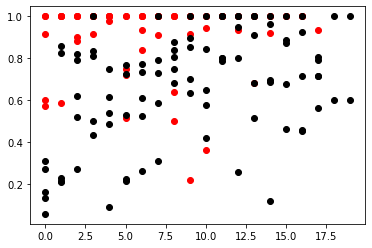

In [54]:
fig,ax = plt.subplots()
KO_vars = np.zeros([5,])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[1]
#     for j,d in enumerate(d_list[:6]):
    block = 0
    block_mask = d['block_number']==block

    lick_varpos = d['lick_acc'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]
    
    block_mask = probes==0
    
    ax.scatter(np.arange(block_mask.sum()),lick_varpos[block_mask],color='red')
    
    fam_var = lick_varpos[block_mask]
    KO_vars[i] = np.nanmean(fam_var)
    
CTRL_vars = np.zeros([5,])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[1]
#     for j,d in enumerate(d_list[:6]):
    block = 0
    block_mask = d['block_number']==block

    lick_varpos = d['lick_acc'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]
    
    block_mask = probes==0
    
    ax.scatter(np.arange(block_mask.sum()),lick_varpos[block_mask],color='black')
    
    fam_var = lick_varpos[block_mask]
    CTRL_vars[i] = np.nanmean(fam_var)
    
        

In [16]:
# look at other metrics

# analyze probe trials

# first 5 trials of each block


<ipython-input-33-0cb915dfdd55>:5: RuntimeWarning: divide by zero encountered in log
  ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'red')
<ipython-input-33-0cb915dfdd55>:9: RuntimeWarning: divide by zero encountered in log
  ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'black')


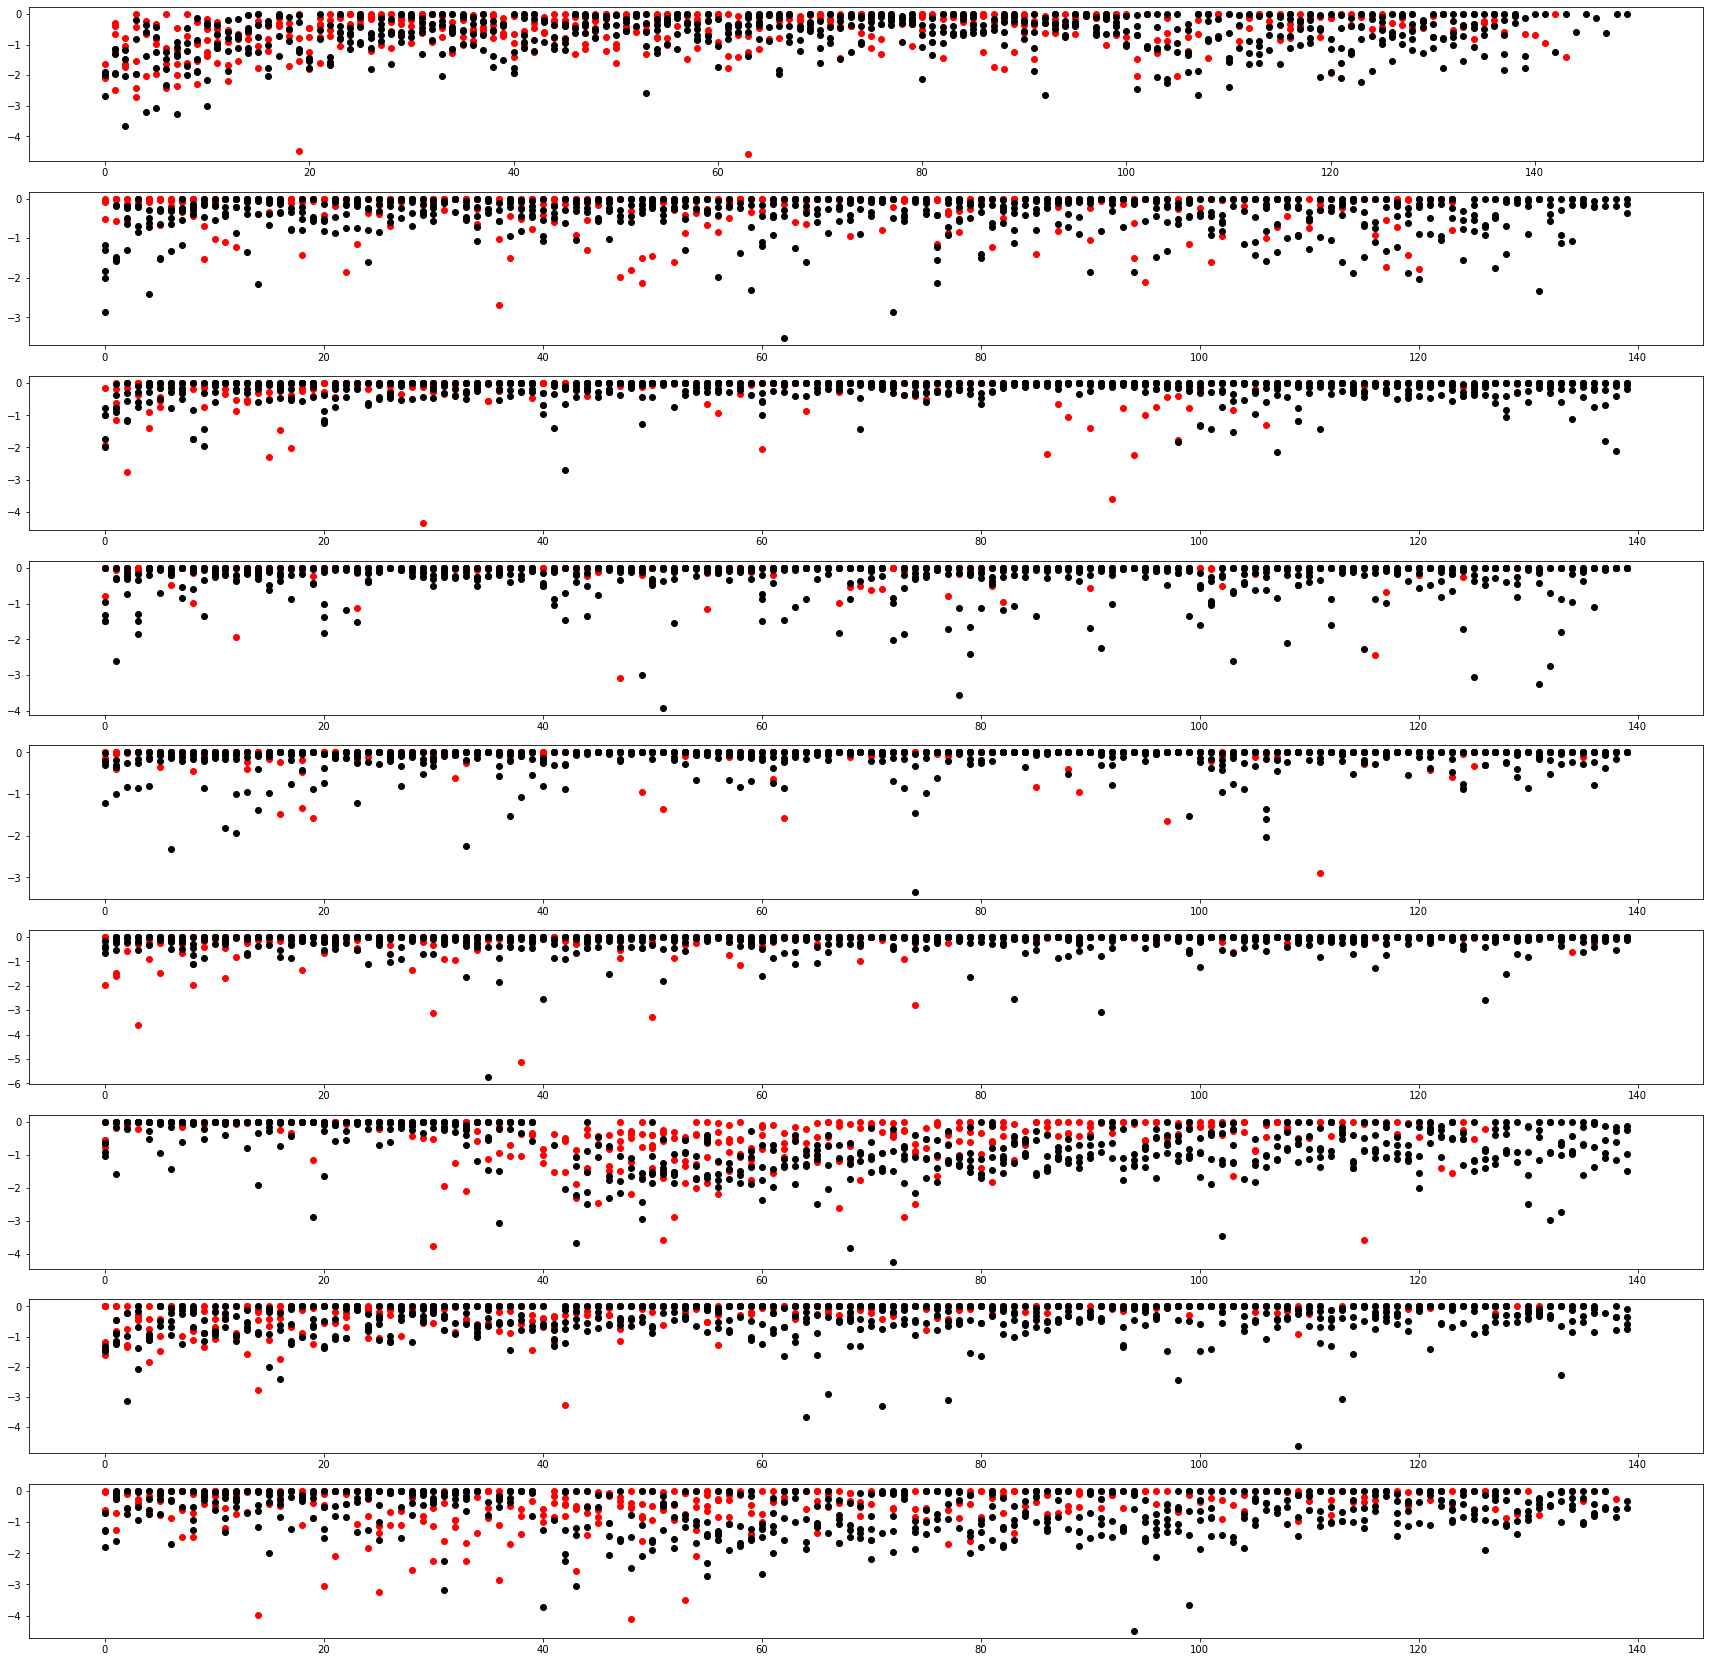

In [33]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'black')
    


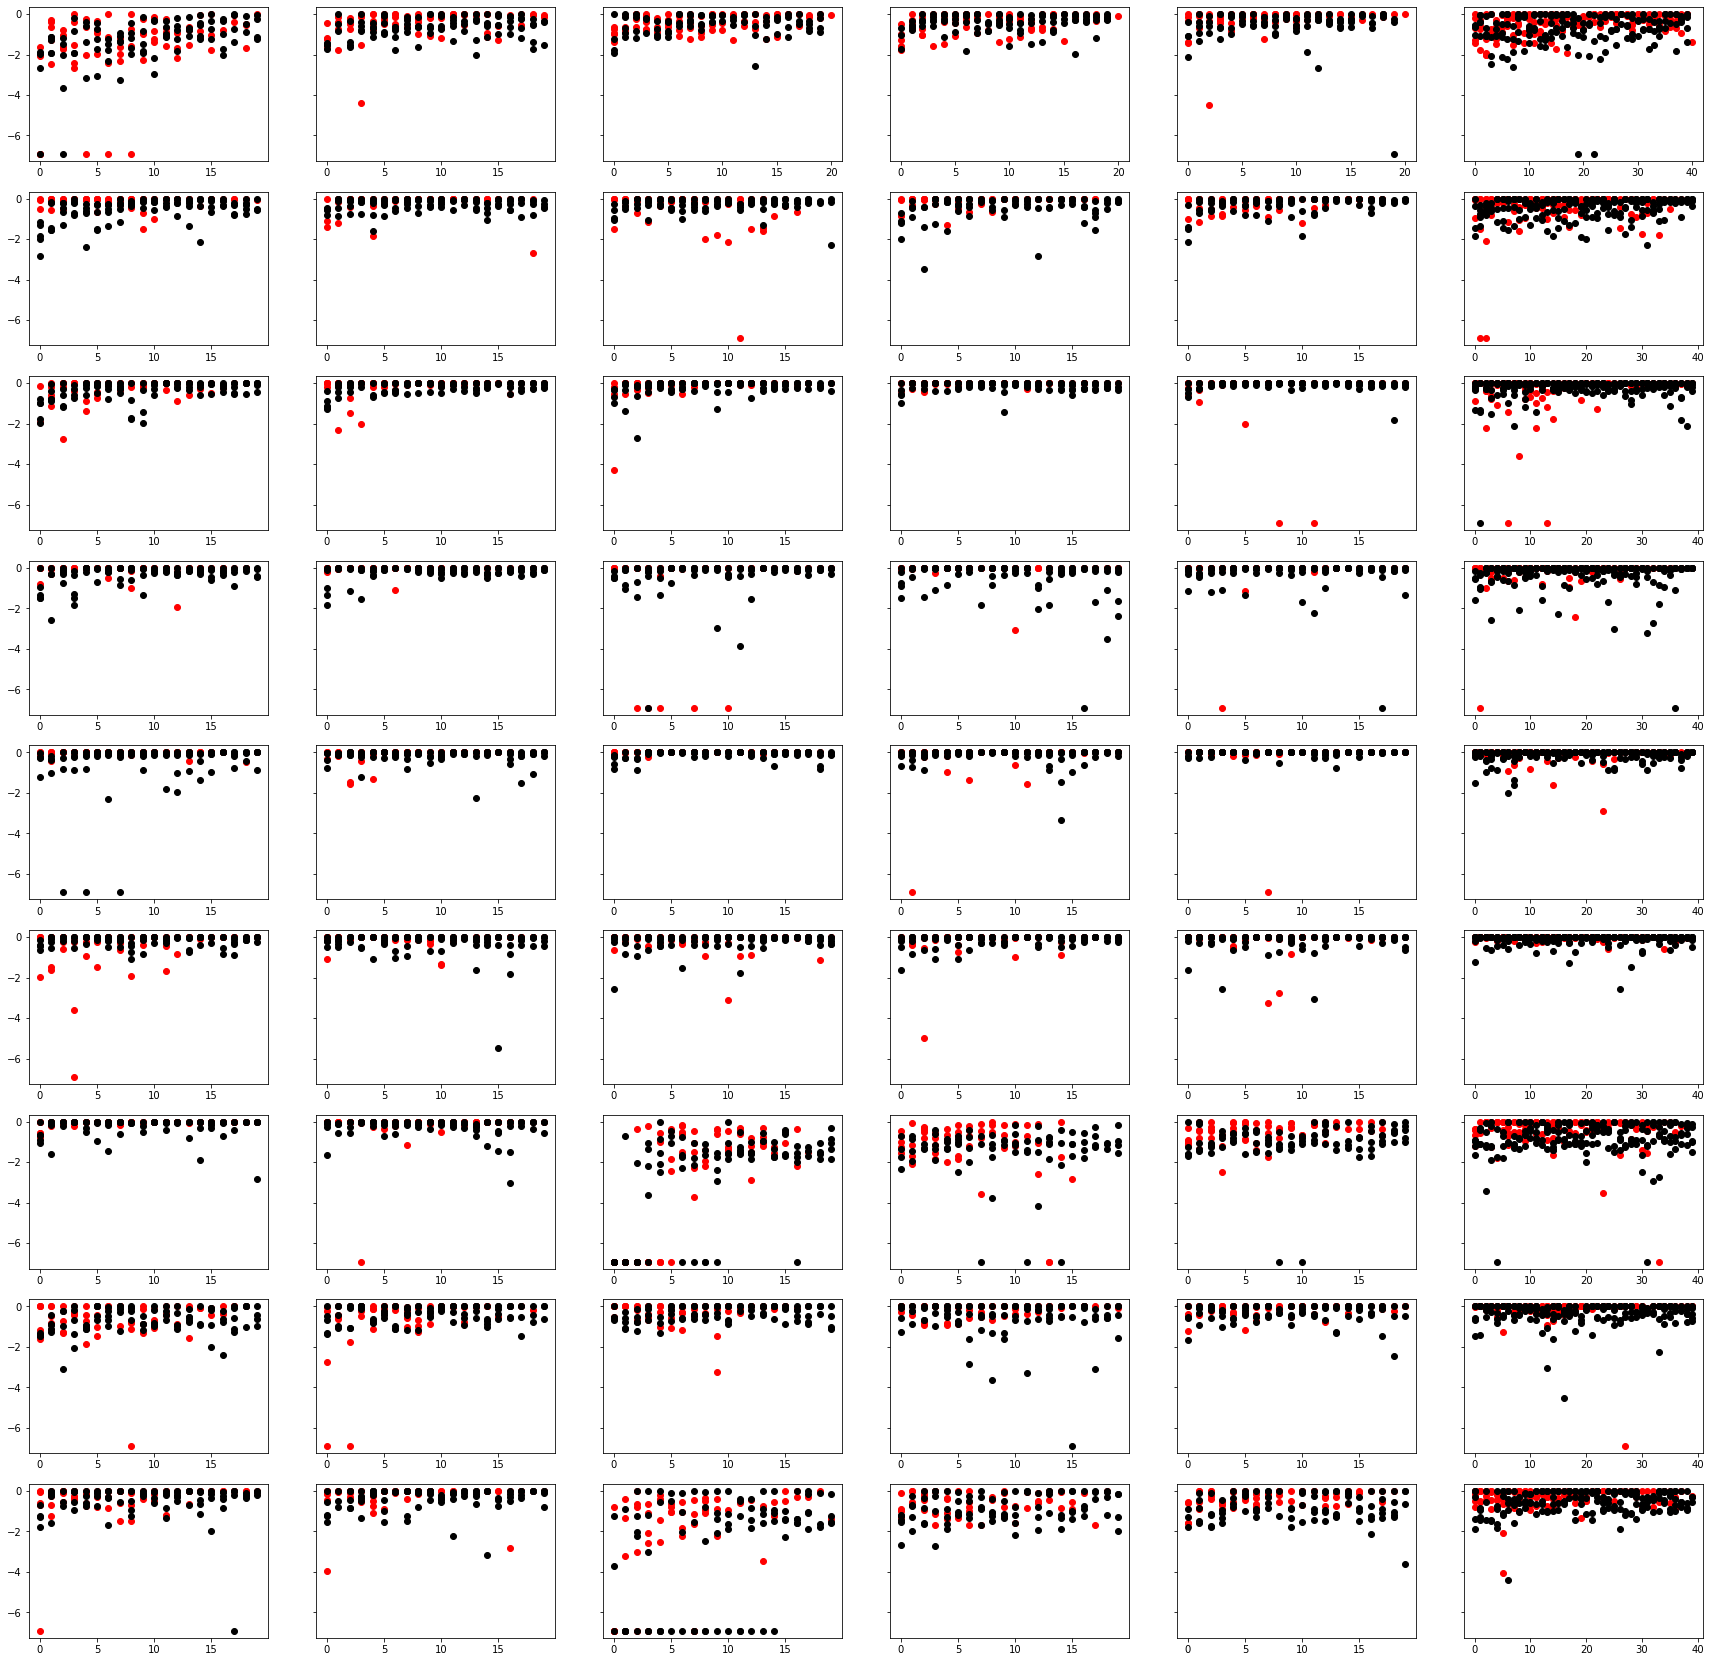

In [18]:
fig,ax = plt.subplots(9,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,9,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-3)
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,9,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-3)
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

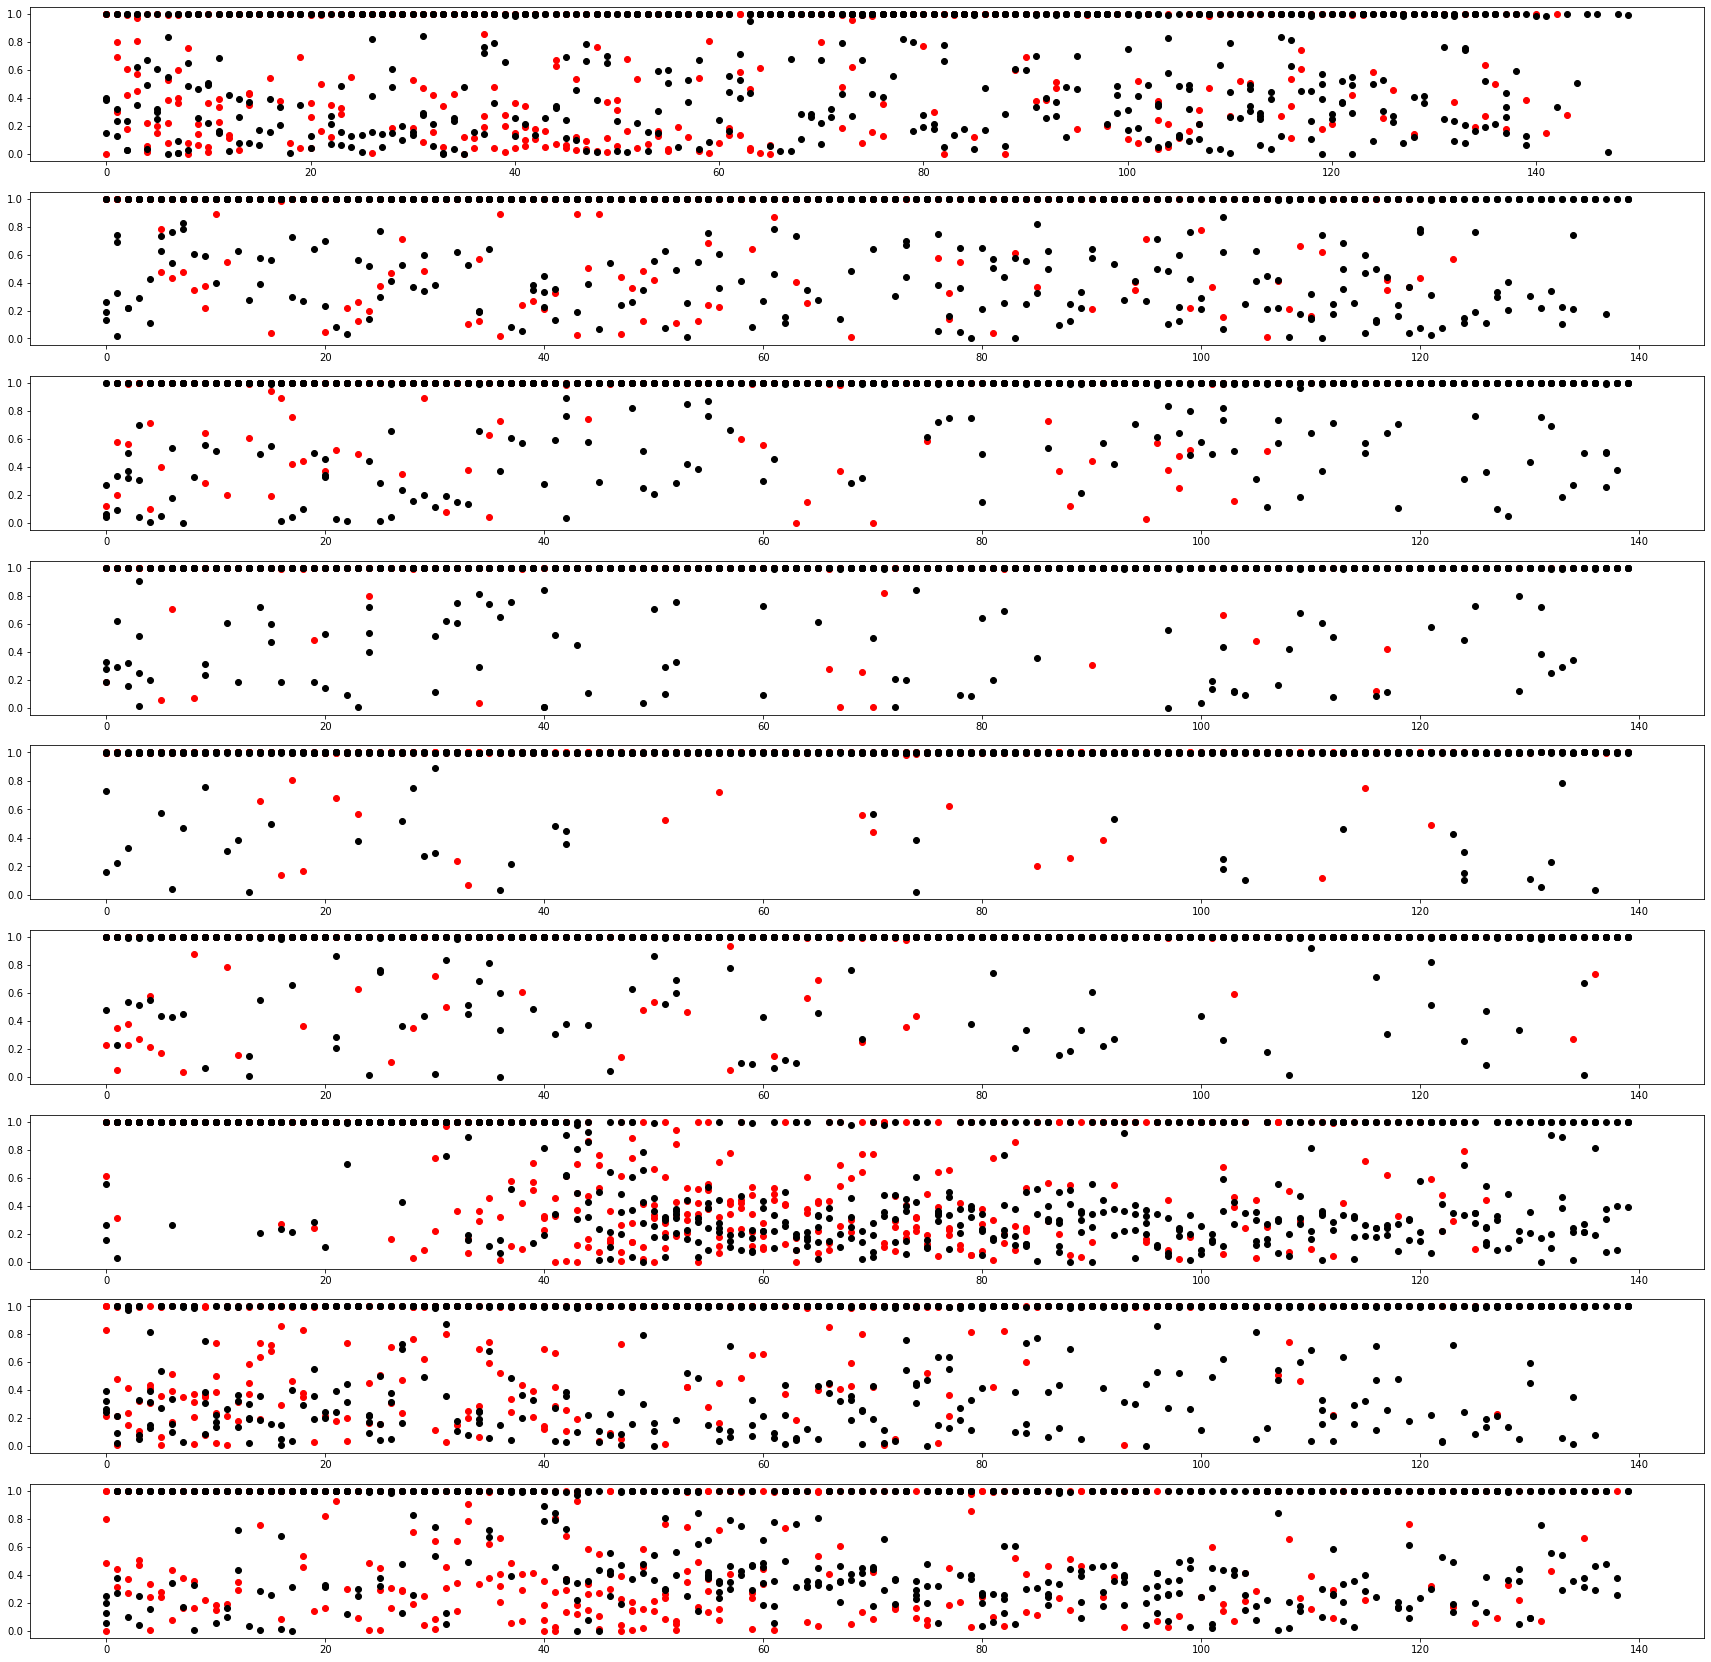

In [19]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.abs(d['lickrate_dprime'][d['probes']==0]), color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.abs(d['lickrate_dprime'][d['probes']==0]), color = 'black')
    


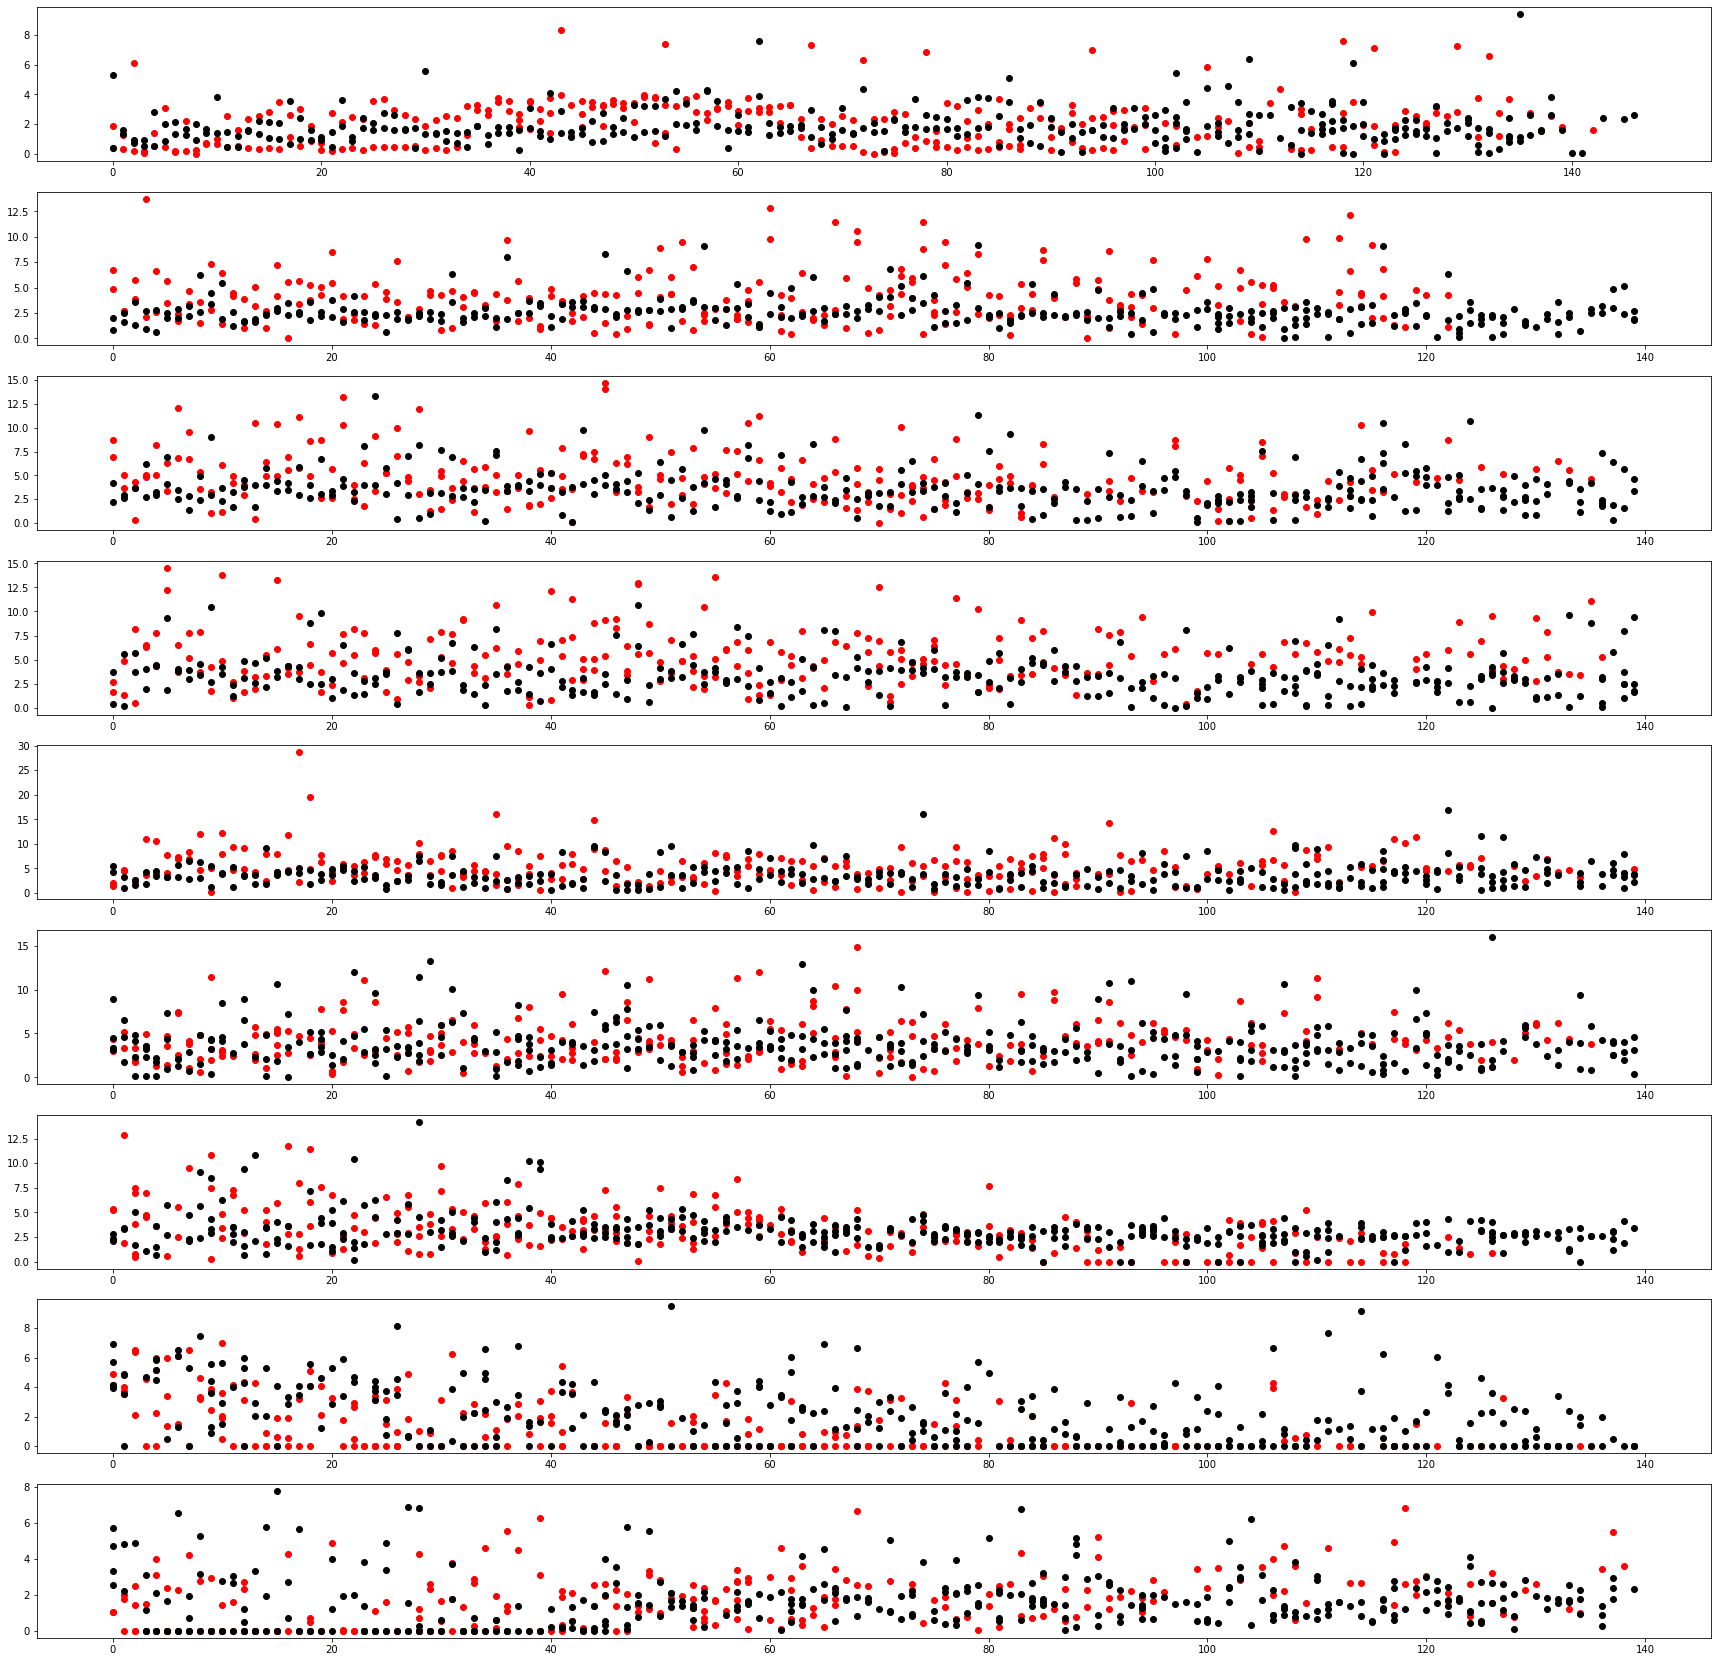

In [20]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'black')
    


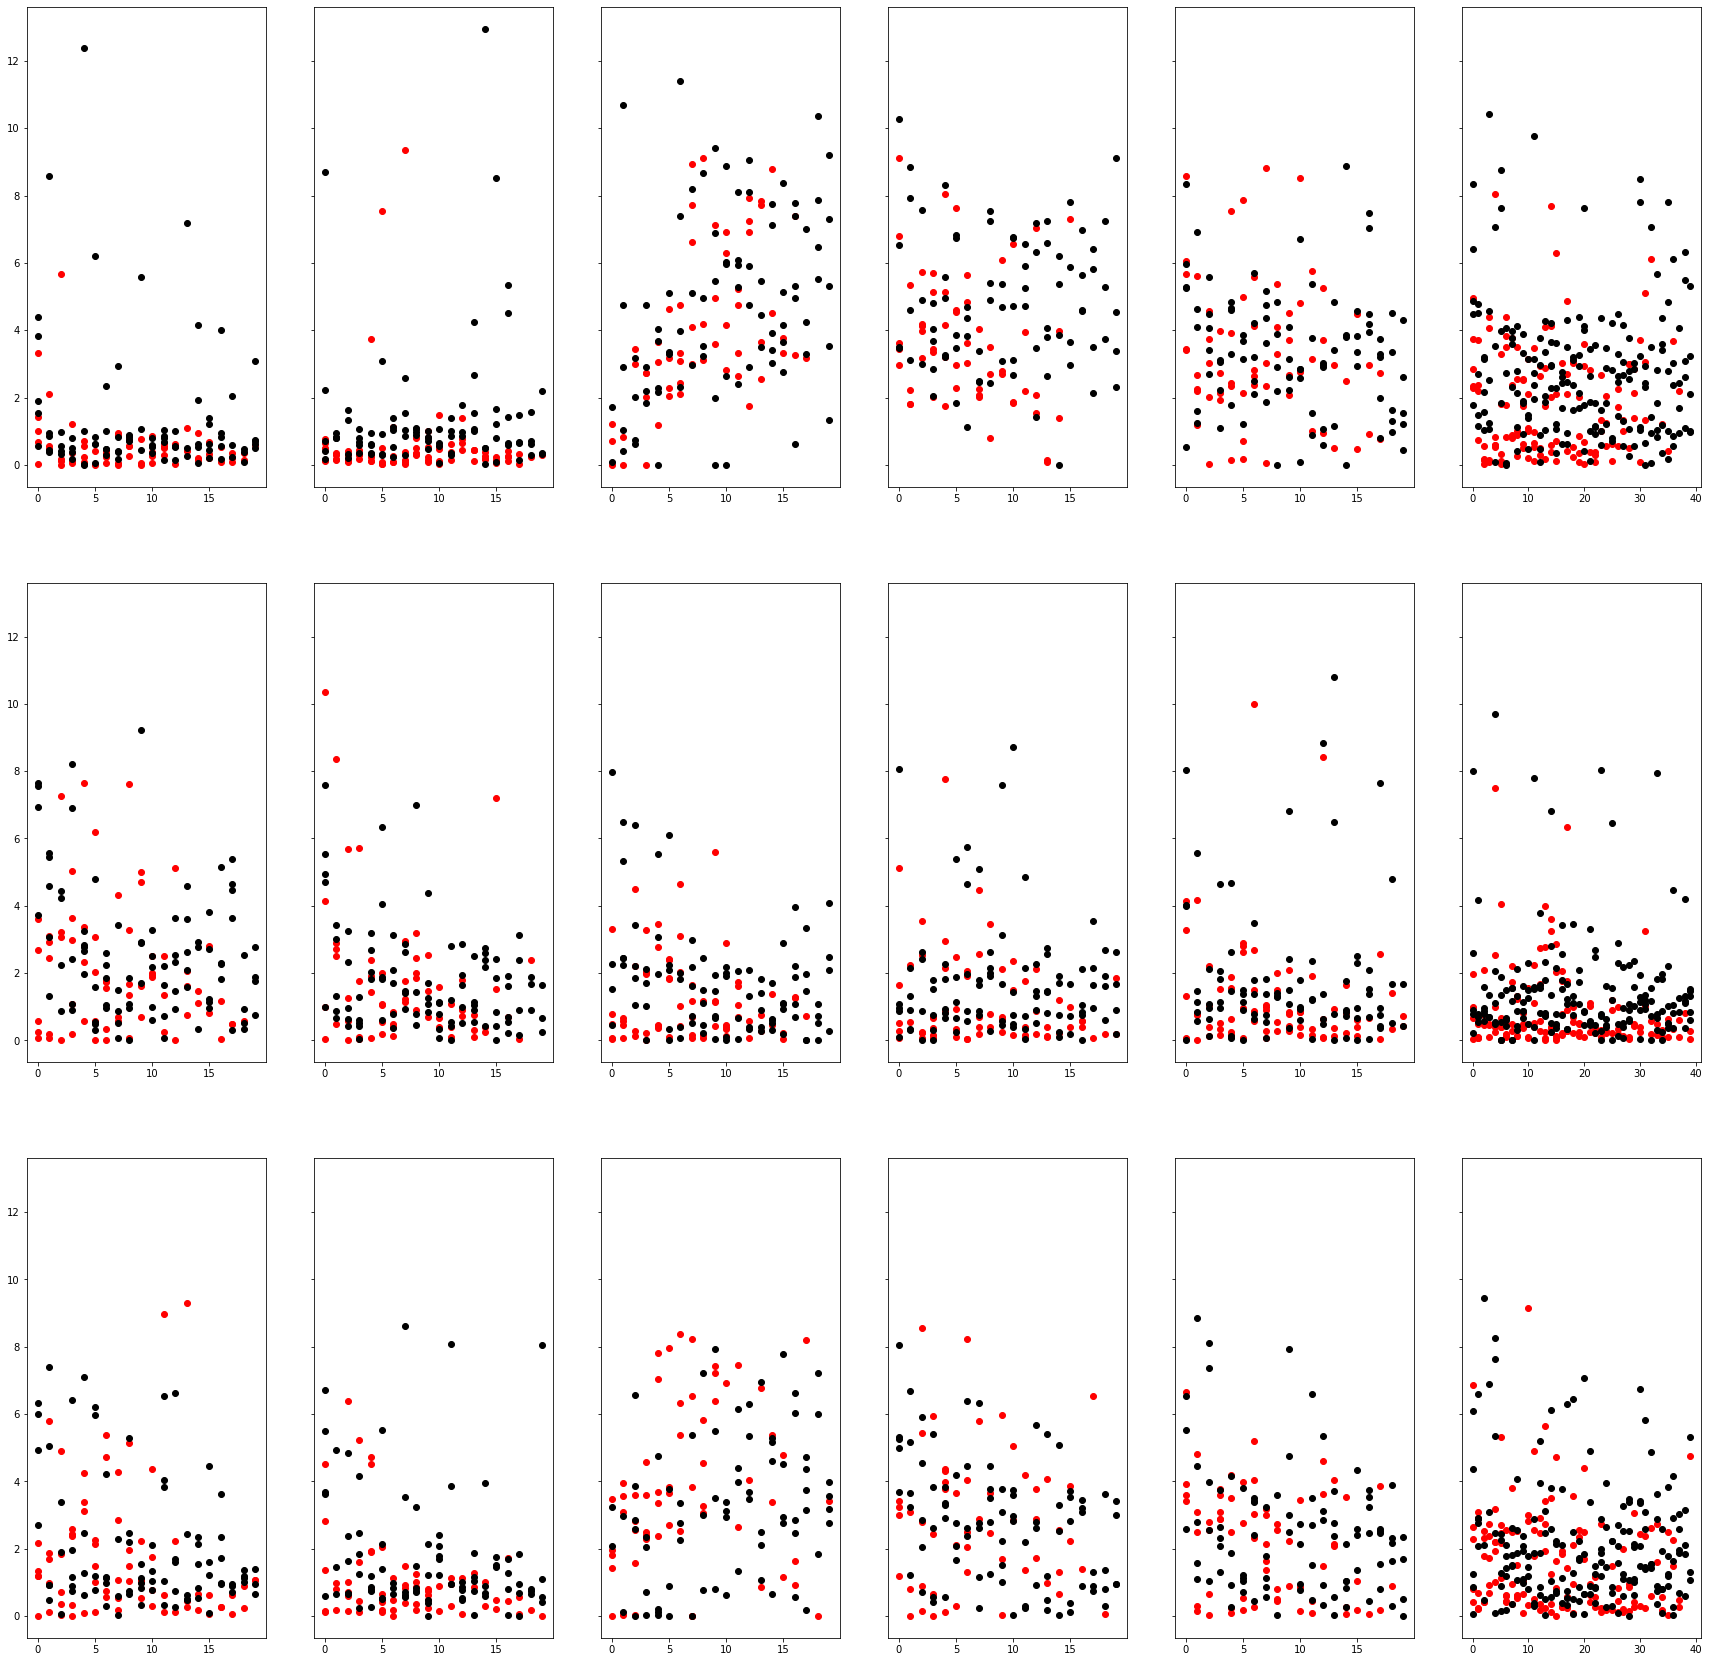

In [21]:
fig,ax = plt.subplots(3,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = d['lick_varpos'][block_mask]
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = d['lick_varpos'][block_mask]
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

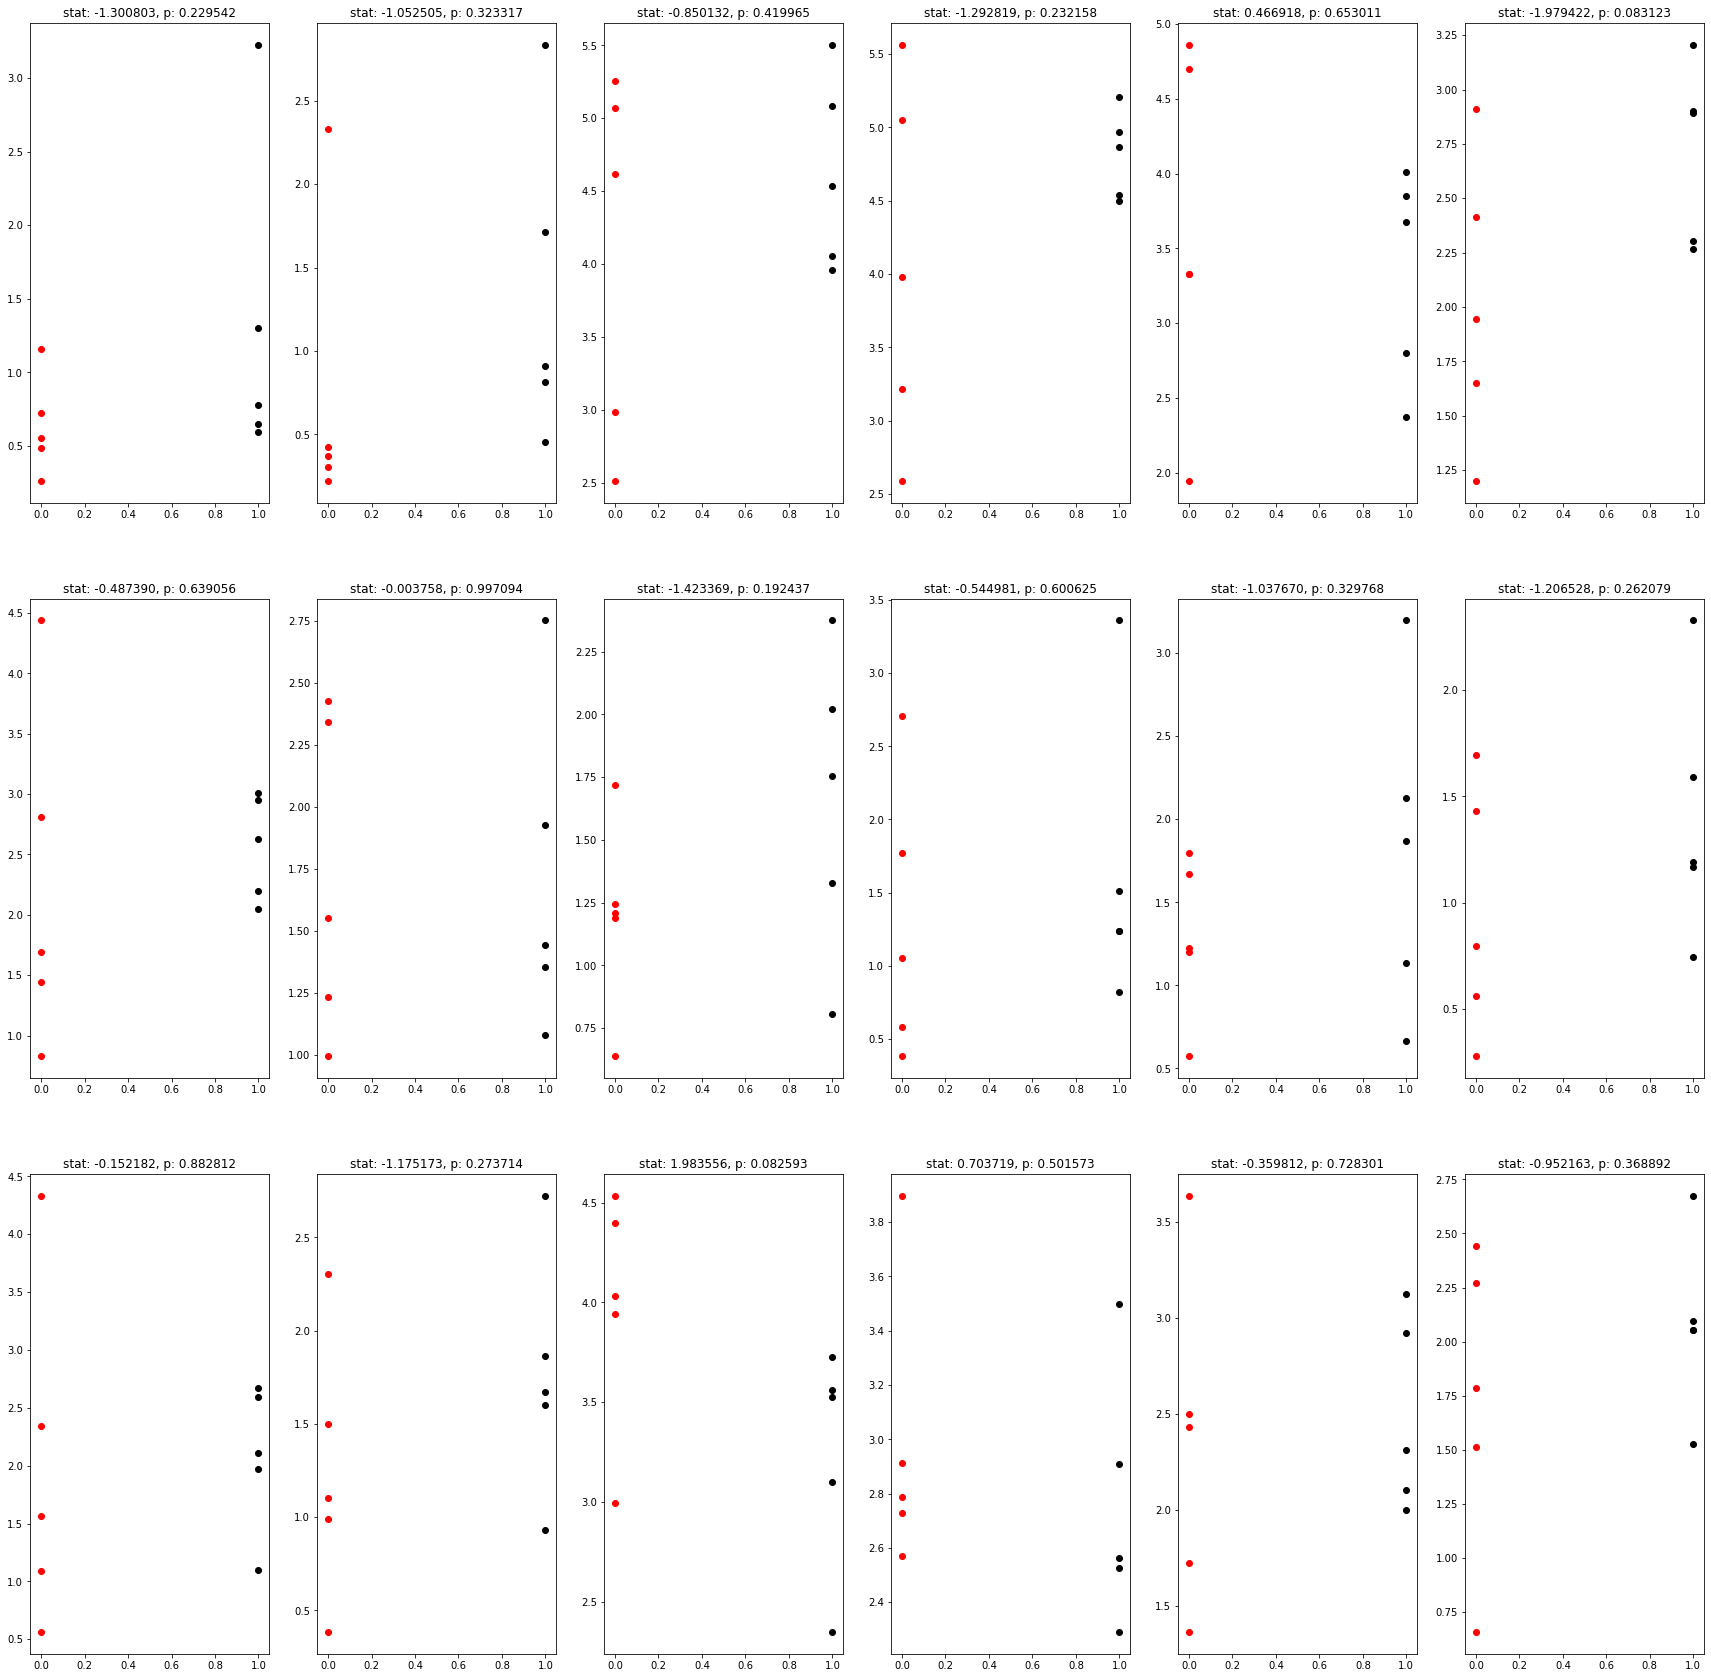

In [22]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
#         stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

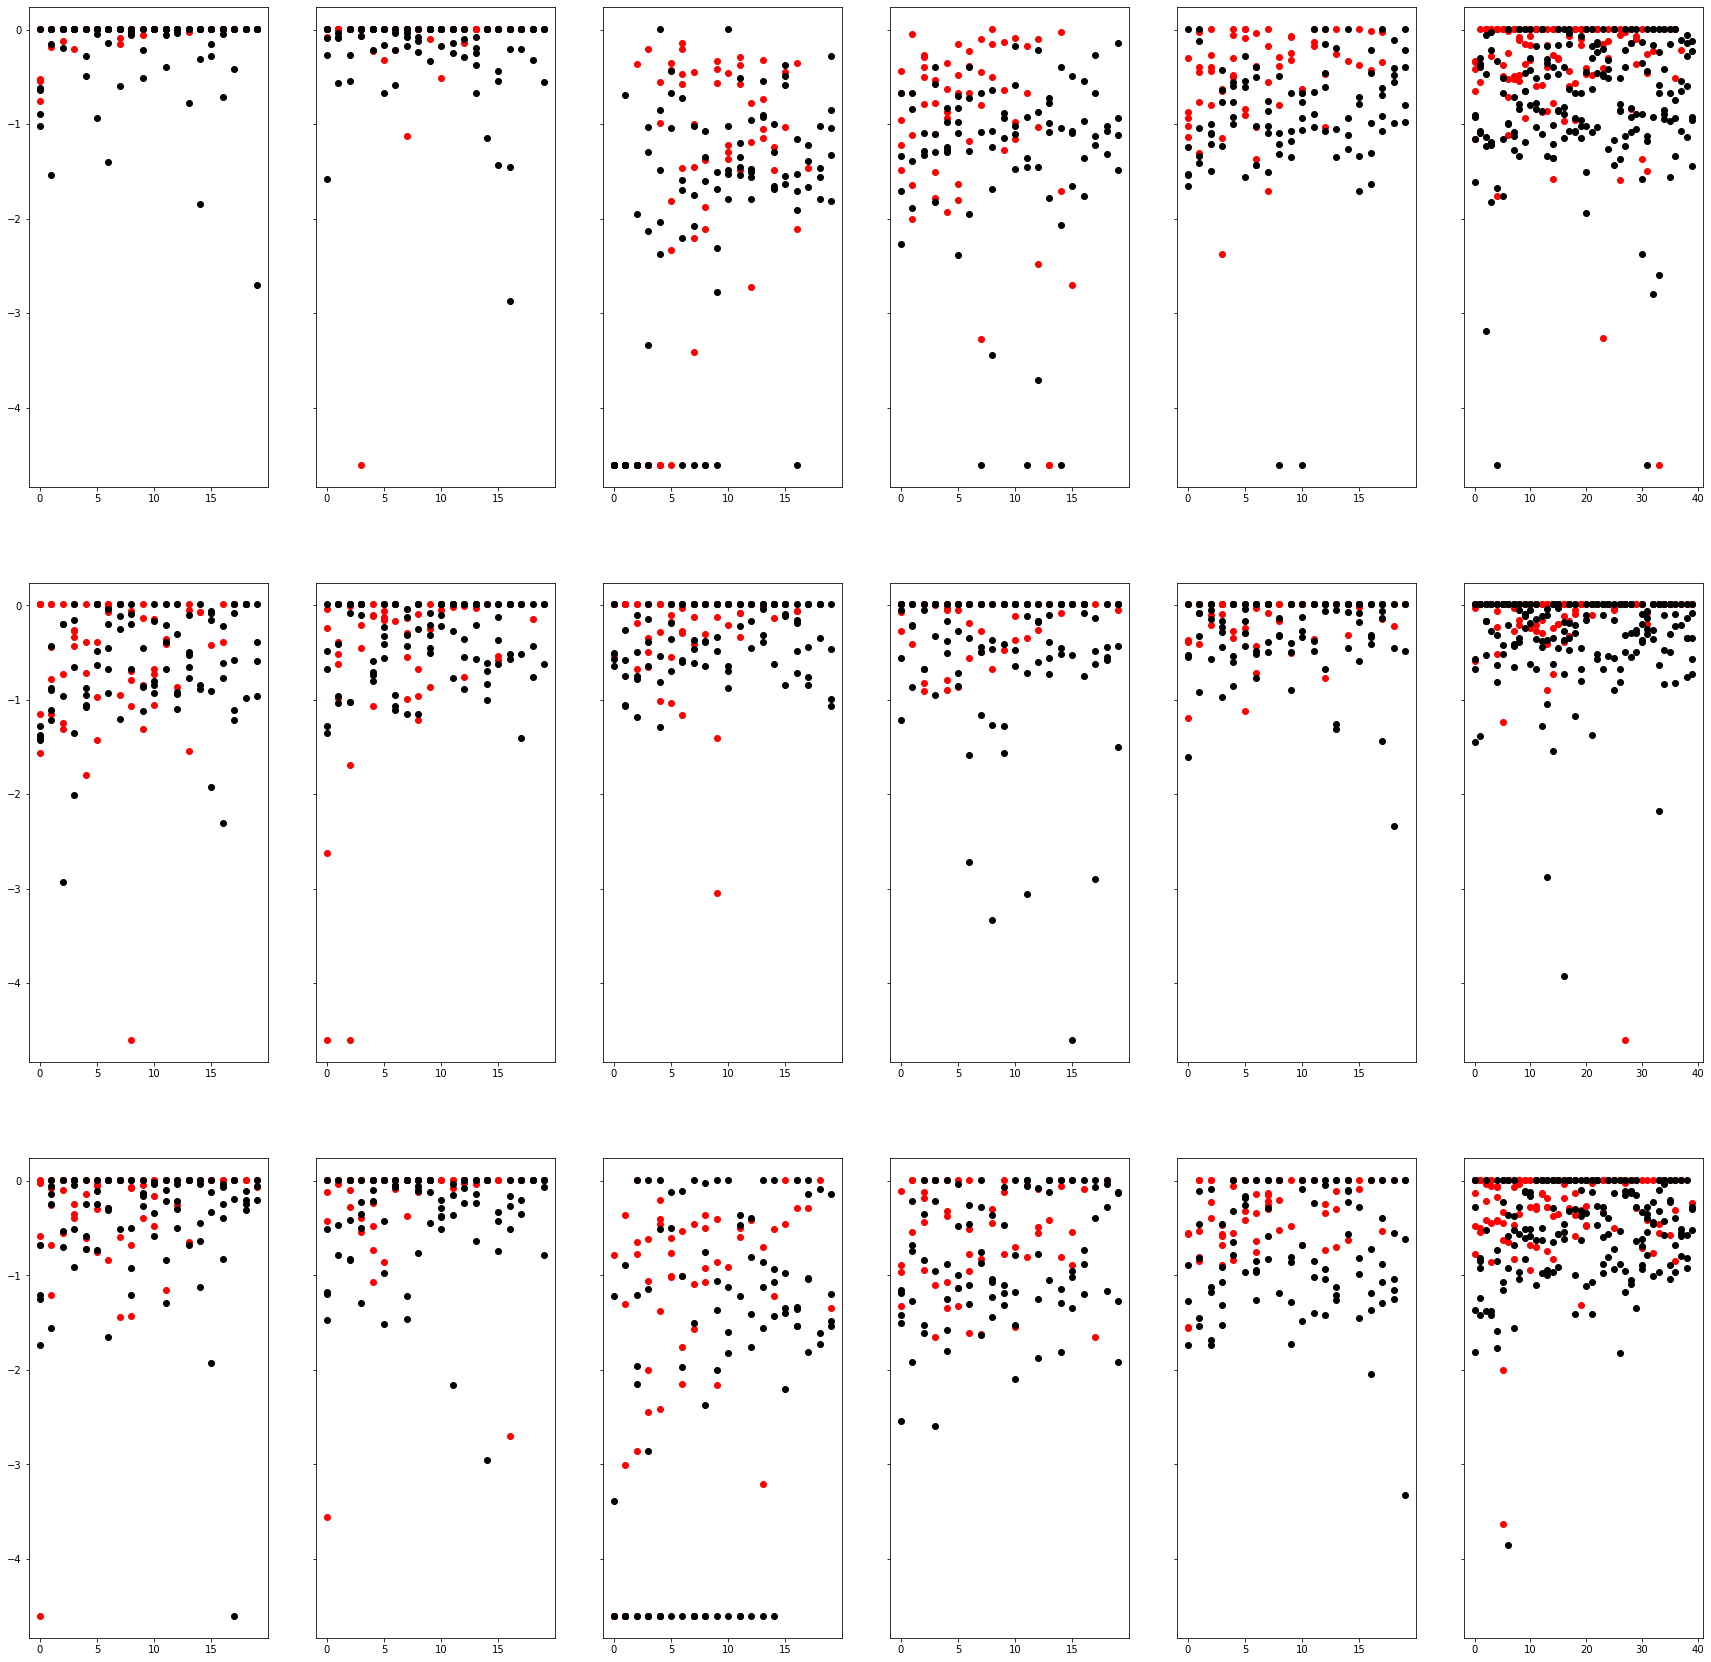

In [23]:
fig,ax = plt.subplots(3,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
#             block_mask = (d['block_number']==block)*(d['LR']==-1)
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-2)
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmedian(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            
#             block_mask = (d['block_number']==block)*(d['LR']==-1)
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-2)
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmedian(lick_varpos[probes==0])

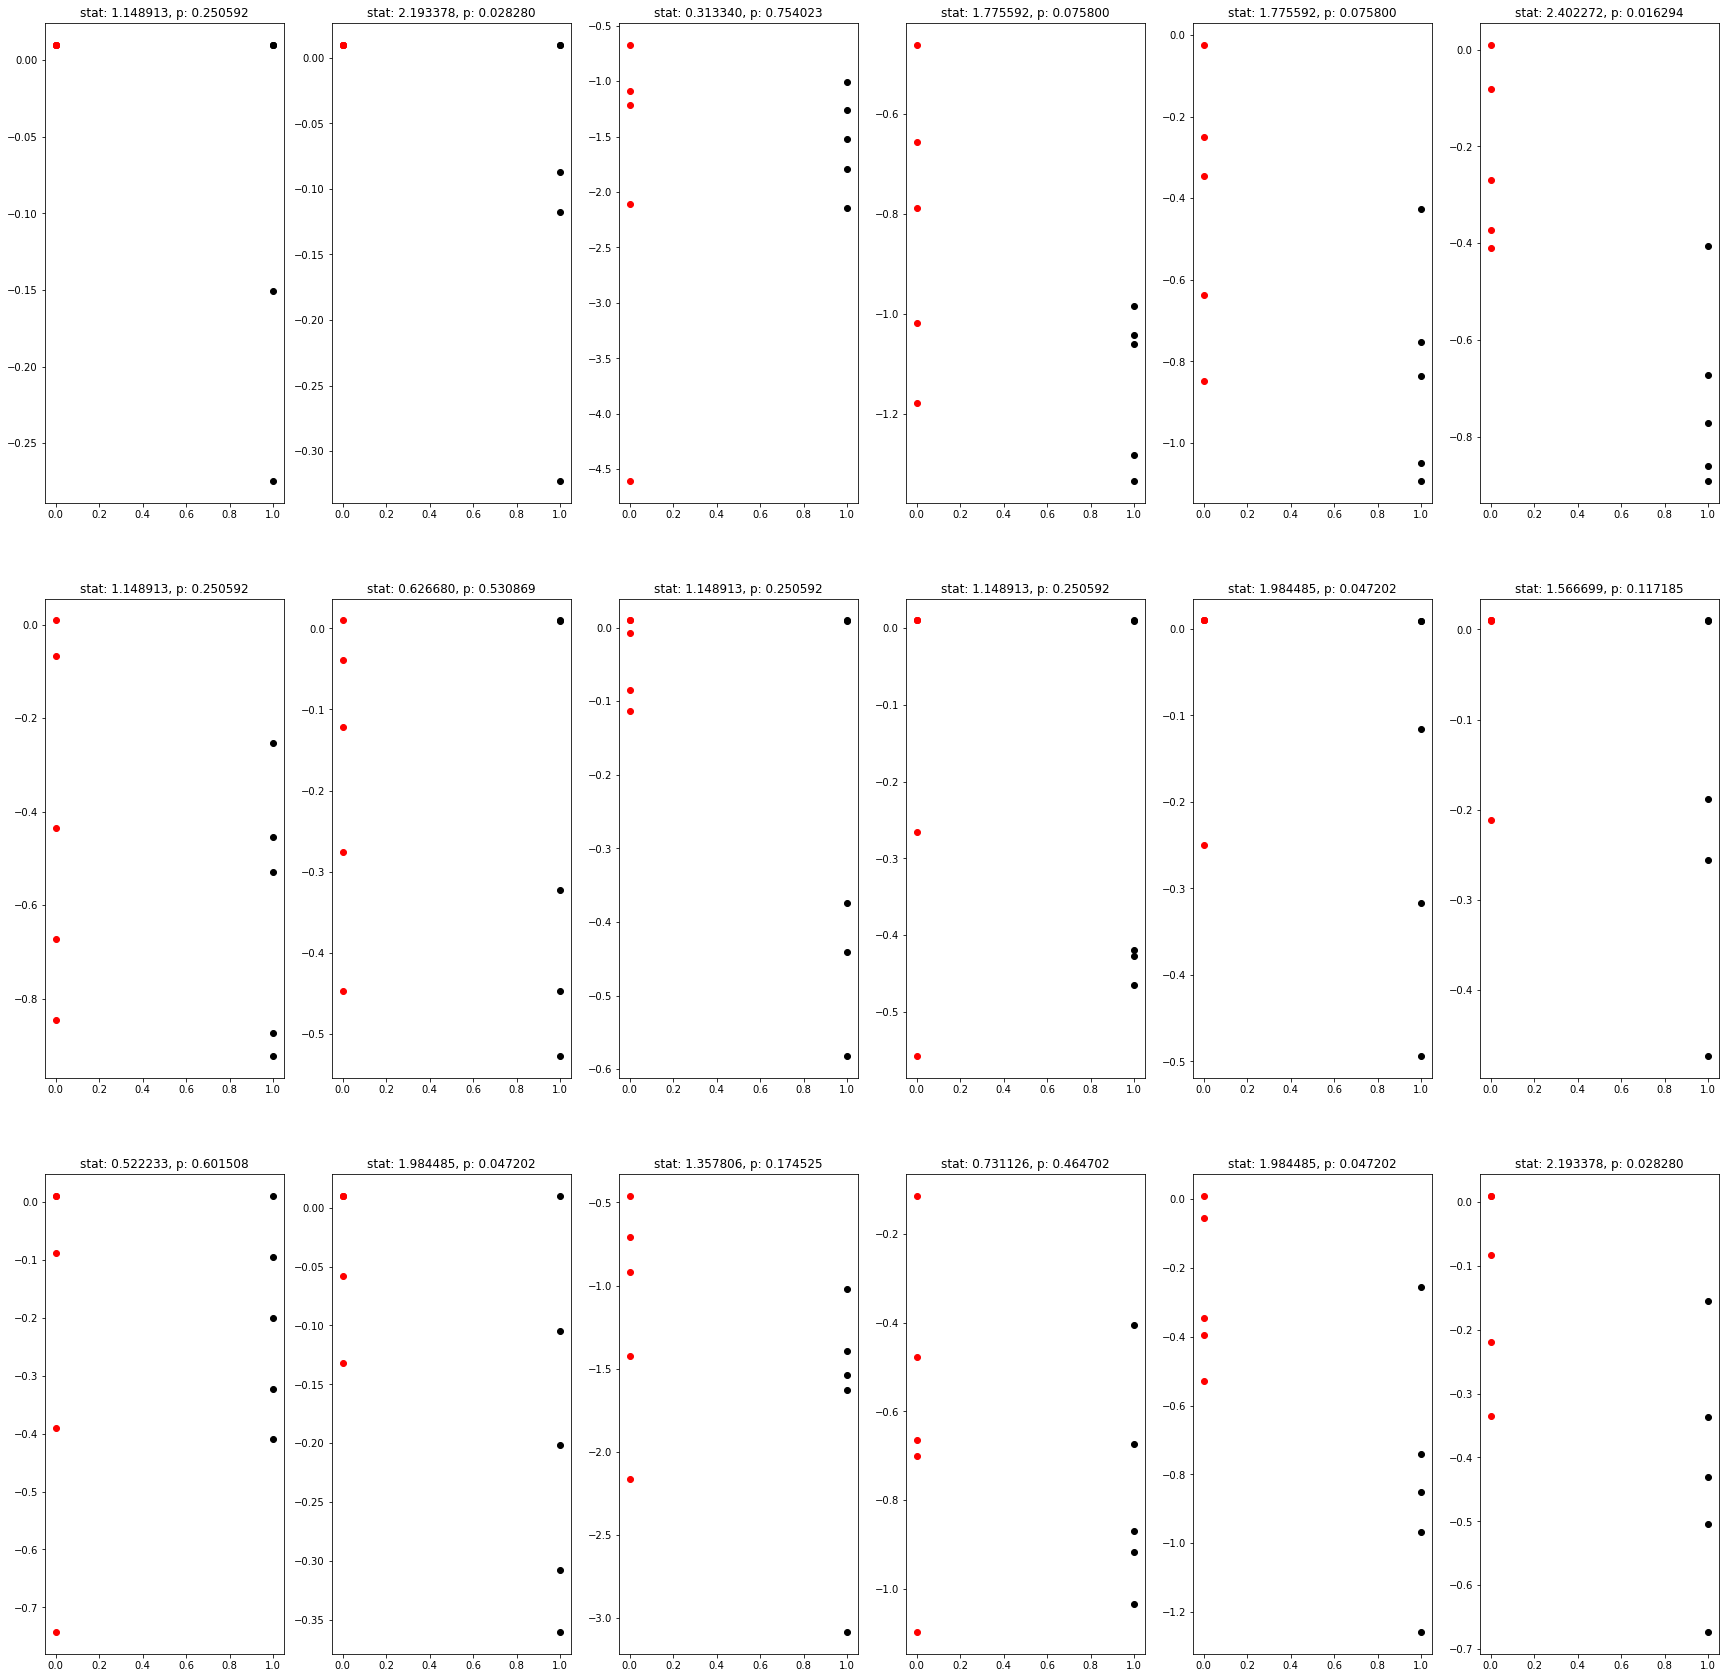

In [24]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
        stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
#         stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

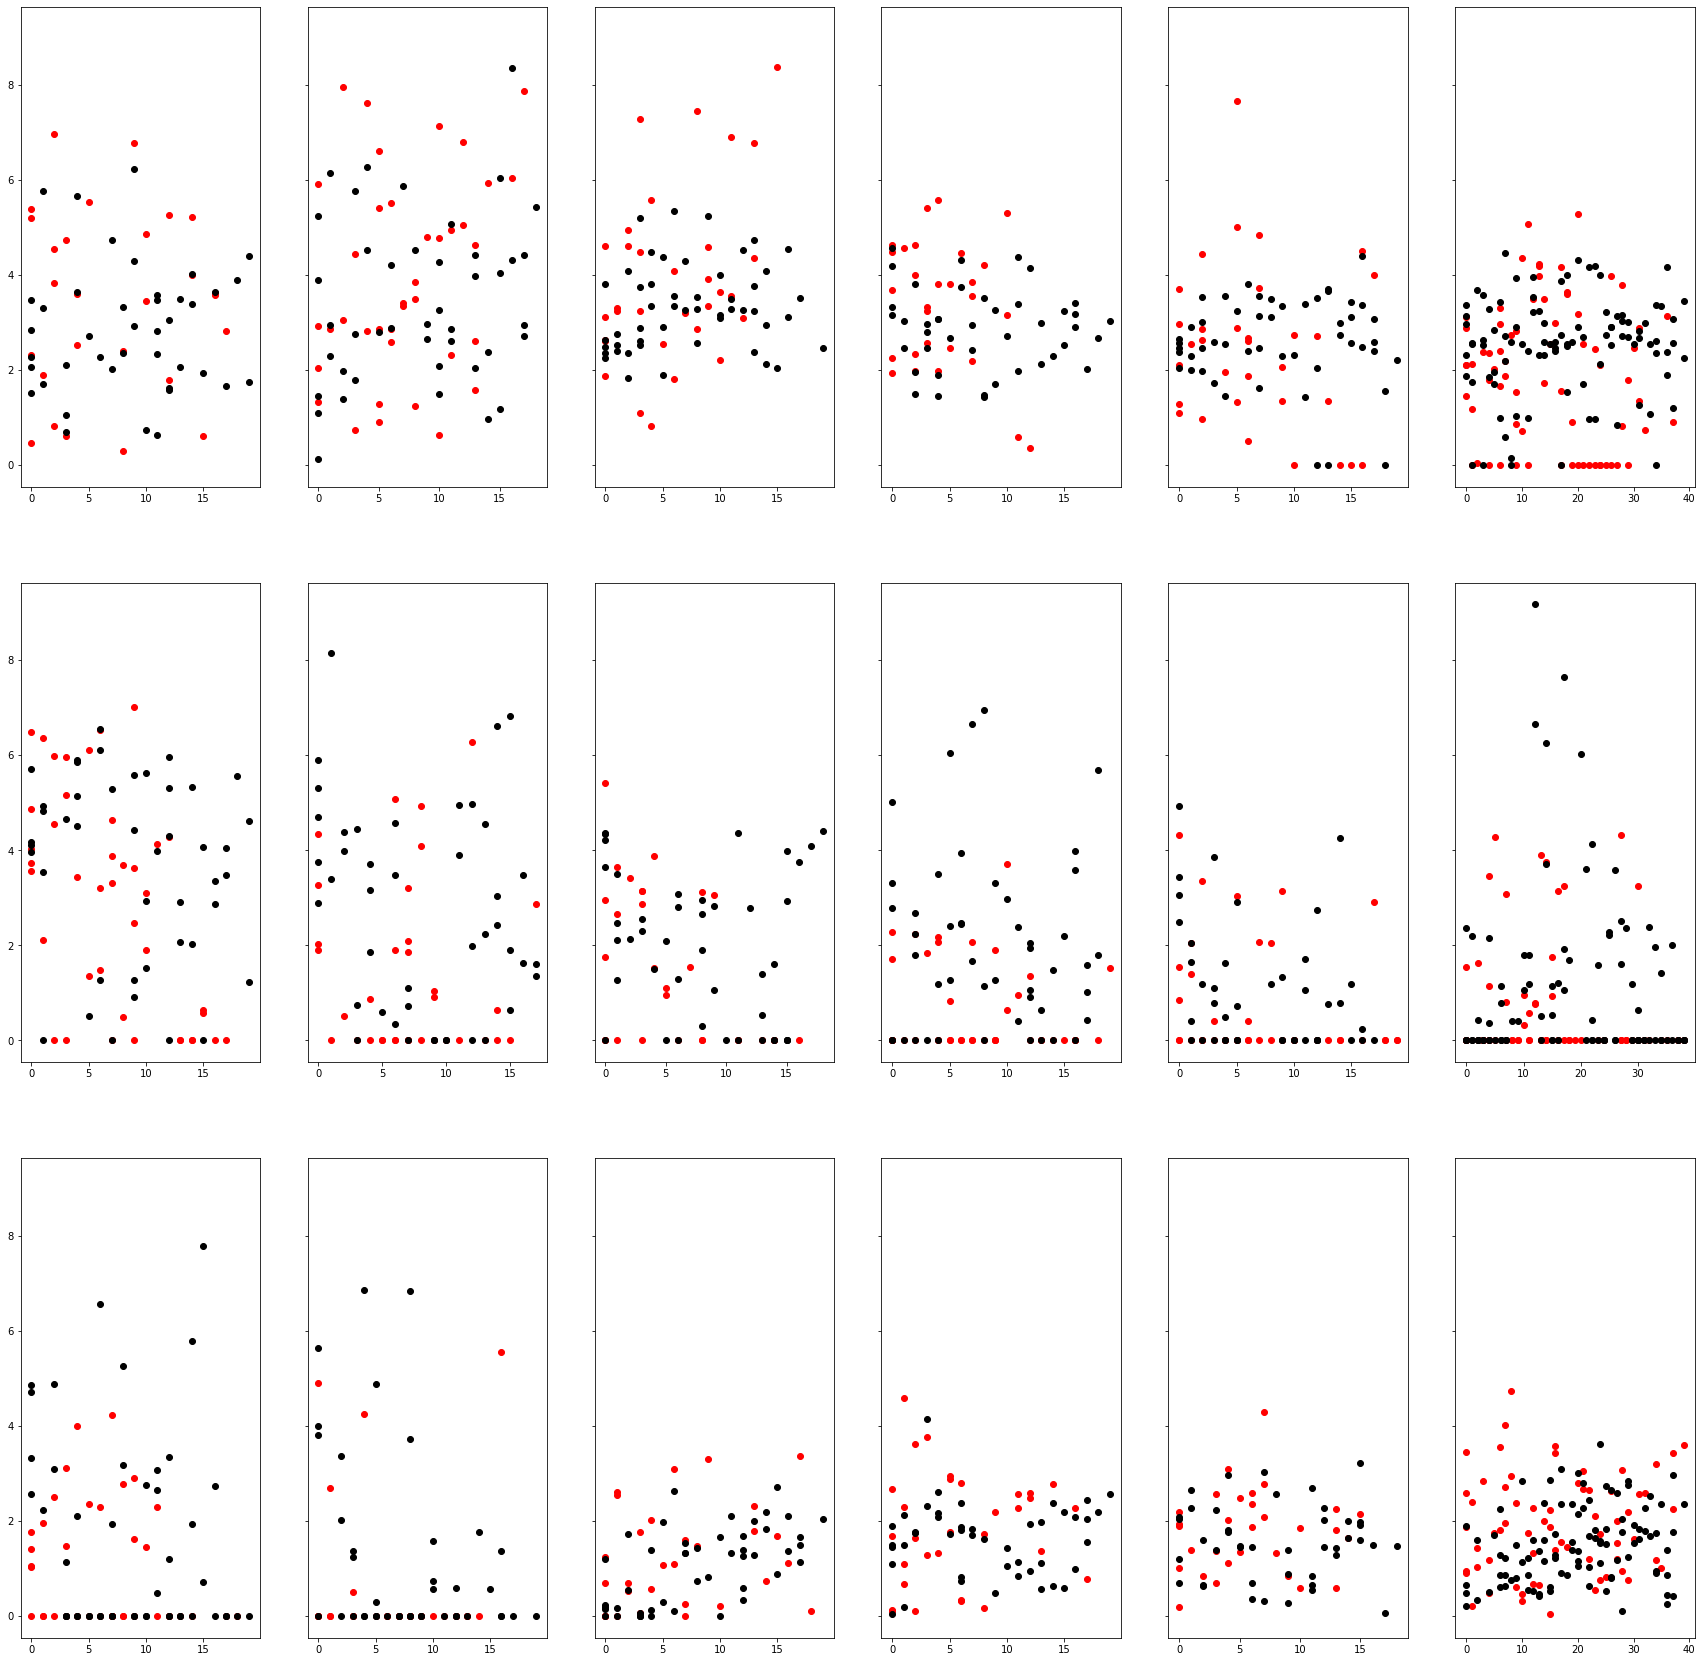

In [25]:
fig,ax = plt.subplots(3,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = (d['block_number']==block)*(d['LR']==-1)
#             block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = d['lickrate_rz_early'][block_mask]
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = (d['block_number']==block)*(d['LR']==-1)
#             block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = d['lickrate_rz_early'][block_mask]
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
Left values [0.9736329  0.02282002] [0.90571845 0.00680965]
p-values [0.752, 0.0]
Right values [0.4026462  0.02572291] [0.41238706 0.01922223]
p-values [1.0, 0.8280000000000001]


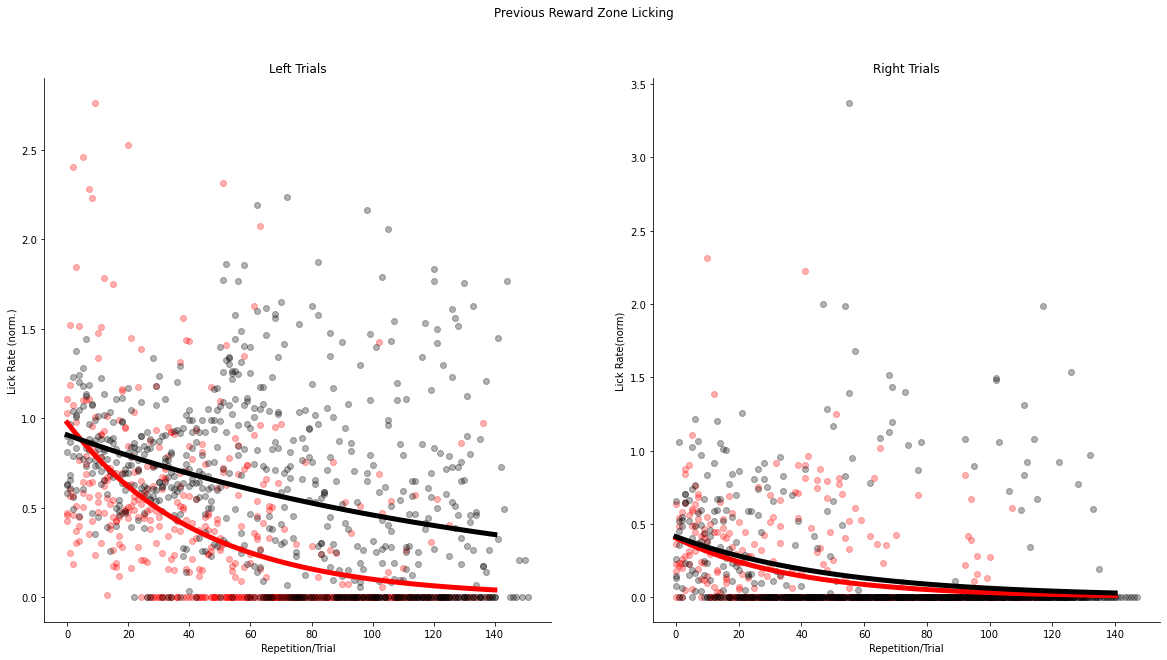

In [70]:
def concat_lickrate(d_list):
    lr_rz_early_norm = []
    lr_rz_late_norm = []
    for j,d in enumerate(d_list):
        if j == 0:
            baseline_early_inds = (d['block_number']<2)*(d['LR']==-1)
            baseline_late_inds = (d['block_number']<2)*(d['LR']==1)
            baseline_early = d['lickrate_rz_early'][baseline_early_inds].mean()
            baseline_late = d['lickrate_rz_late'][baseline_late_inds].mean()


            nonbaseline_inds = d['block_number']>=2
            lr_rz_early_norm.append(d['lickrate_rz_early'][nonbaseline_inds*(d['LR']==-1)]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][nonbaseline_inds*(d['LR']==1)]/baseline_late)

        elif j ==1 :    
            nonbaseline_inds = d['LR']==-1
            lr_rz_early_norm.append(d['lickrate_rz_early'][d['LR']==-1]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][d['LR']==1]/baseline_late)
        else:
            nonbaseline_inds = d['block_number']<2
            lr_rz_early_norm.append(d['lickrate_rz_early'][nonbaseline_inds*(d['LR']==-1)]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][nonbaseline_inds*(d['LR']==1)]/baseline_late)

    lr_rz_early_norm = np.concatenate(lr_rz_early_norm)
    lr_rz_late_norm = np.concatenate(lr_rz_late_norm)

    inds_early = np.arange(lr_rz_early_norm.shape[0])
    inds_late = np.arange(lr_rz_late_norm.shape[0])
        
        
    return {'early_rz_inds': inds_early, 'early_rz_lr': lr_rz_early_norm, 'late_rz_inds':inds_late, 'late_rz_lr': lr_rz_late_norm}




def run_reversal_lrs(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_lickrate(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
    
    CTRL_reversal_lrs={mouse:concat_lickrate(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_early_popt, KO_early_pcov = curve_fit(monoexp_decay, KO_concat_lrs['early_rz_inds'], KO_concat_lrs['early_rz_lr'] )
    CTRL_early_popt, CTRL_early_pcov = curve_fit(monoexp_decay, CTRL_concat_lrs['early_rz_inds'], CTRL_concat_lrs['early_rz_lr'] )
    
    early_true_diff = np.abs(KO_early_popt-CTRL_early_popt)
    
    KO_late_popt, KO_late_pcov = curve_fit(monoexp_decay, KO_concat_lrs['late_rz_inds'], KO_concat_lrs['late_rz_lr'])
    CTRL_late_popt, CTRL_late_pcov = curve_fit(monoexp_decay, CTRL_concat_lrs['late_rz_inds'], CTRL_concat_lrs['late_rz_lr'])
    
    late_true_diff = np.abs(KO_late_popt - CTRL_late_popt)
    
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    early_perm_diff, late_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
        
    
    
        l0_early_popt, l0_early_pcov = curve_fit(monoexp_decay, l0_concat_lrs['early_rz_inds'], l0_concat_lrs['early_rz_lr'])
        l1_early_popt, l1_early_pcov = curve_fit(monoexp_decay, l1_concat_lrs['early_rz_inds'], l1_concat_lrs['early_rz_lr'])
    
        early_perm_diff.append(np.abs(l0_early_popt-l1_early_popt))
    
        l0_late_popt, l0_late_pcov = curve_fit(monoexp_decay, l0_concat_lrs['late_rz_inds'], l0_concat_lrs['late_rz_lr'])
        l1_late_popt, l1_late_pcov = curve_fit(monoexp_decay, l1_concat_lrs['late_rz_inds'], l1_concat_lrs['late_rz_lr'])
    
        late_perm_diff.append(np.abs(l0_late_popt - l1_early_popt))
        
    early_perm_diff = np.array(early_perm_diff)
    late_perm_diff = np.array(late_perm_diff)
    print('Left values', KO_early_popt, CTRL_early_popt)
    print('p-values', [1-np.float((early_true_diff[i]>=early_perm_diff[:,i]).sum())/early_perm_diff.shape[0] for i in range(2)])
    
    print('Right values', KO_late_popt, CTRL_late_popt)
    print('p-values', [1-np.float((late_true_diff[i]>=late_perm_diff[:,i]).sum())/late_perm_diff.shape[0] for i in range(2)])
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['early_rz_inds'],KO_concat_lrs['early_rz_lr'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['early_rz_inds'],CTRL_concat_lrs['early_rz_lr'],color='black',alpha=.3)

    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay(t, *KO_early_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay(t, *CTRL_early_popt), color='black',linewidth=5)
    
    
    ax[1].scatter(KO_concat_lrs['late_rz_inds'],KO_concat_lrs['late_rz_lr'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['late_rz_inds'],CTRL_concat_lrs['late_rz_lr'],color='black',alpha=.3)
    
    ax[1].plot(t, monoexp_decay(t, *KO_late_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_decay(t, *CTRL_late_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('Lick Rate (norm.)')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('Lick Rate(norm)')
    ax[1].set_title('Right Trials')
    return fig, ax
    
    



fig,ax = run_reversal_lrs(KO_sessions,CTRL_sessions)
fig.savefig(os.path.join(figdir_local,"LickingExtinction.pdf"),format = 'pdf')
fig.savefig(os.path.join(figdir_local,"LickingExctinction.png"),format = 'png')
    
    
    



[-0.02607434  0.01673519  0.1272216 ]
dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
[-0.02607434  0.01673519  0.1272216 ] [-0.00592626  0.00889762 -0.0213185 ]
(250, 3) (250, 3)
Left values [ 1.55733837  0.02571456 -0.98603693] [ 1.57000741  0.05823739 -0.63663489]
p-values [0.532, 0.09599999999999997, 0.31599999999999995]
Right values [ 1.56408115  0.06713501 -0.65795339] [ 1.57000741  0.05823739 -0.63663489]
p-values [0.508, 0.404, 0.54]


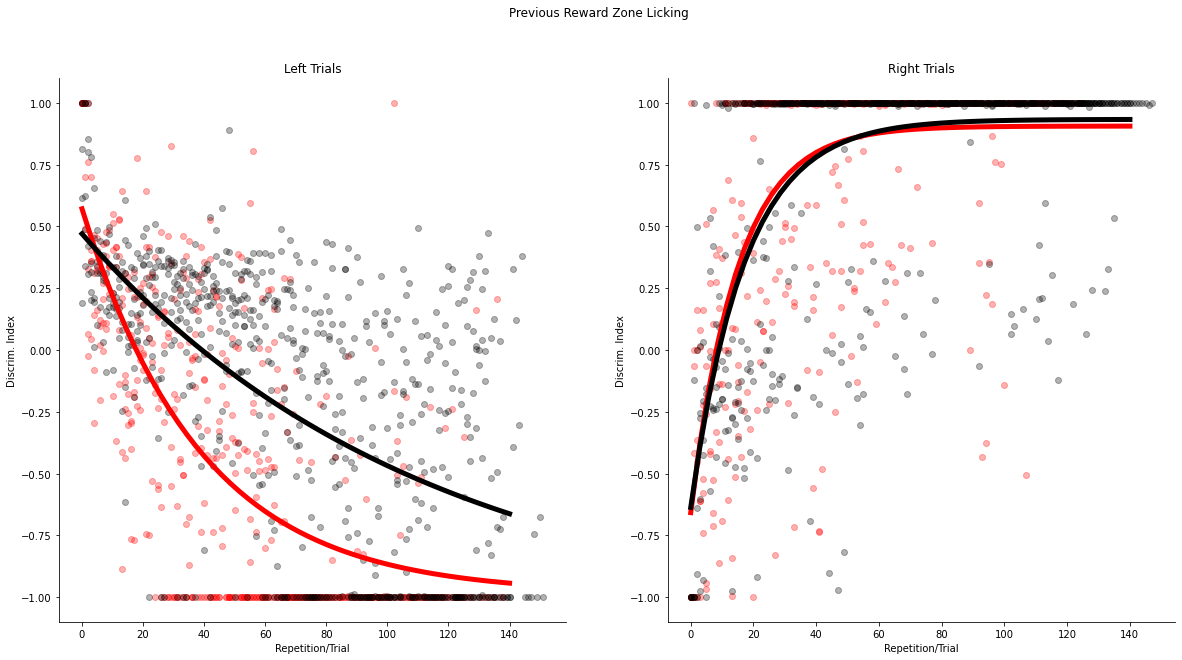

In [73]:
def concat_discrim(d_list):
    lr_discrim_left = []
    lr_discrim_right = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:    
            nonbaseline_inds = d['block_number']>=2
            lr_discrim_left.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_discrim_left.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_discrim_left.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_discrim_left = np.concatenate(lr_discrim_left)
    lr_discrim_right = np.concatenate(lr_discrim_right)

    inds_left = np.arange(lr_discrim_left.shape[0])
    inds_right = np.arange(lr_discrim_right.shape[0])
        
        
    return {'left_inds': inds_left, 'left_discrim': lr_discrim_left, 'right_inds':inds_right, 'right_discrim': lr_discrim_right}




def run_reversal_discrim(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_discrim(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
    
    CTRL_reversal_lrs={mouse:concat_discrim(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_left_popt, KO_left_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['left_inds'], KO_concat_lrs['left_discrim'])
    CTRL_left_popt, CTRL_left_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['left_inds'], CTRL_concat_lrs['left_discrim'])
    
    left_true_diff = KO_left_popt-CTRL_left_popt
    print(left_true_diff)
    
    KO_right_popt, KO_right_pcov = curve_fit(monoexp_growth_wint, KO_concat_lrs['right_inds'], KO_concat_lrs['right_discrim'], maxfev=int(1E5))
    CTRL_right_popt, CTRL_right_pcov = curve_fit(monoexp_growth_wint, CTRL_concat_lrs['right_inds'], CTRL_concat_lrs['right_discrim'], maxfev=int(1E5))
    
    right_true_diff = KO_right_popt - CTRL_right_popt
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['left_inds'],KO_concat_lrs['left_discrim'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['left_inds'],CTRL_concat_lrs['left_discrim'],color='black',alpha=.3)

    ax[1].scatter(KO_concat_lrs['right_inds'],KO_concat_lrs['right_discrim'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['right_inds'],CTRL_concat_lrs['right_discrim'],color='black',alpha=.3)
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    left_perm_diff, right_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
        
    
    
        l0_left_popt, l0_left_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['left_inds'], l0_concat_lrs['left_discrim'], maxfev=int(1E5))
        l1_left_popt, l1_left_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['left_inds'], l1_concat_lrs['left_discrim'], maxfev=int(1E5))
    
        left_perm_diff.append(l0_left_popt-l1_left_popt)
    
        l0_right_popt, l0_right_pcov = curve_fit(monoexp_growth_wint, l0_concat_lrs['right_inds'], l0_concat_lrs['right_discrim'], maxfev=int(1E5))
        l1_right_popt, l1_right_pcov = curve_fit(monoexp_growth_wint, l1_concat_lrs['right_inds'], l1_concat_lrs['right_discrim'], maxfev=int(1E5))
    
        right_perm_diff.append(l0_right_popt - l1_right_popt)
        
    left_perm_diff = np.array(left_perm_diff)
    right_perm_diff = np.array(right_perm_diff)
    
    print(left_true_diff, right_true_diff)
    print(left_perm_diff.shape, right_perm_diff.shape)
    print('Left values', KO_left_popt, CTRL_right_popt)
    print('p-values', [1-np.float((left_true_diff[i]>=left_perm_diff[:,i]).sum())/left_perm_diff.shape[0] for i in range(3)])
    
    print('Right values', KO_right_popt, CTRL_right_popt)
    print('p-values', [1-np.float((right_true_diff[i]>=right_perm_diff[:,i]).sum())/right_perm_diff.shape[0] for i in range(3)])
    
    
    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay_wint(t, *KO_left_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay_wint(t, *CTRL_left_popt), color='black',linewidth=5)
    
    
    
    
    ax[1].plot(t, monoexp_growth_wint(t, *KO_right_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_growth_wint(t, *CTRL_right_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('Discrim. Index')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('Discrim. Index')
    ax[1].set_title('Right Trials')
    
    



run_reversal_discrim(KO_sessions,CTRL_sessions)
    
    
    

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-84-54ebe55280a2>:138: RuntimeWarning: overflow encountered in exp
  return (a-c)*np.exp(-b*x) + c


[1.41994427e-02 4.00260201e+01 3.89089658e-02]
dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
[1.41994427e-02 4.00260201e+01 3.89089658e-02] [0.06176446 3.31762054 0.03834637]
(250, 3) (250, 3)
Left values [3.83302851e-02 4.12788067e+01 6.58679879e-02] [0.0955467  0.35034927 0.22312586]
p-values [0.5840000000000001, 0.06399999999999995, 0.12]
Right values [0.03378224 3.66796981 0.18477949] [0.0955467  0.35034927 0.22312586]
p-values [0.43200000000000005, 0.48, 0.008000000000000007]


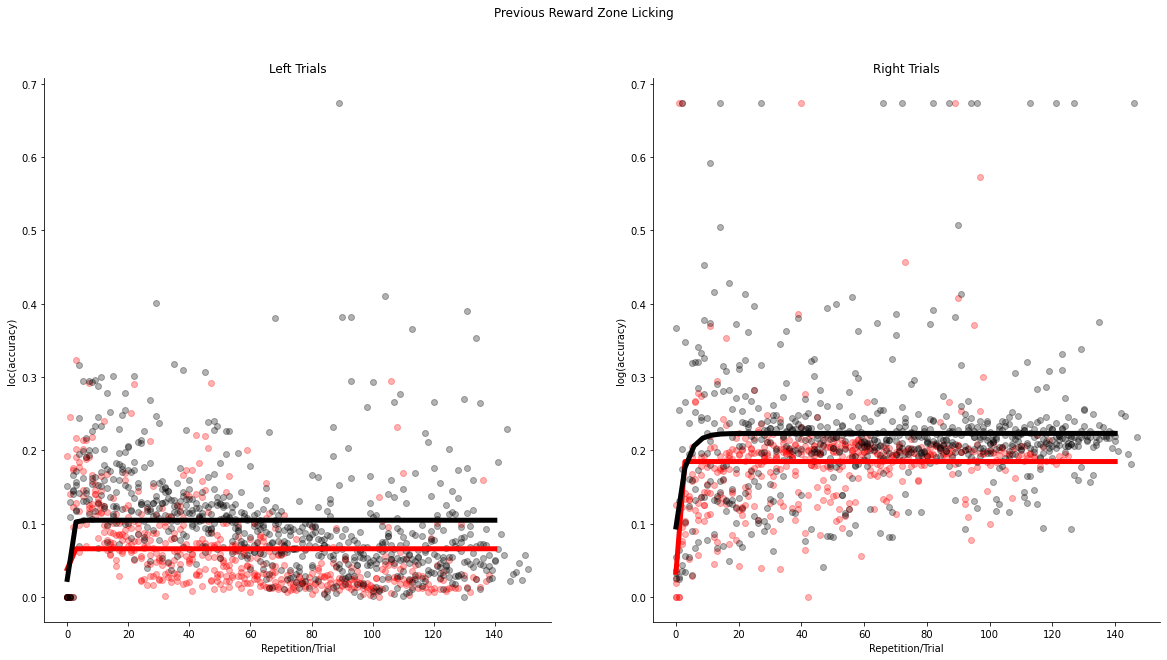

In [90]:
def concat_acc(d_list):
    lr_acc_left = []
    lr_acc_right = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:    
            nonbaseline_inds = d['block_number']>=2
            lr_acc_left.append(d['lick_err'][nonbaseline_inds*(d['LR']==-1)])
            lr_acc_right.append(d['lick_err'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_acc_left.append(d['lick_err'][(d['LR']==-1)])
            lr_acc_right.append(d['lick_err'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_acc_left.append(d['lick_err'][nonbaseline_inds*(d['LR']==-1)])
            lr_acc_right.append(d['lick_err'][nonbaseline_inds*(d['LR']==1)])
            
    lr_acc_left = np.concatenate(lr_acc_left)
    lr_acc_right = np.concatenate(lr_acc_right)

    inds_left = np.arange(lr_acc_left.shape[0])
    inds_right = np.arange(lr_acc_right.shape[0])
        
        
    return {'left_inds': inds_left, 'left_acc': lr_acc_left, 'right_inds':inds_right, 'right_acc': lr_acc_right}

def monoexp_rise(x,a,b):
    return a*(1-np.exp(-b*x)) 


def run_reversal_acc(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_acc(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['left_inds', 'left_acc', 'right_inds', 'right_acc'])
    
    CTRL_reversal_lrs={mouse:concat_acc(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['left_inds', 'left_acc', 'right_inds', 'right_acc'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_left_popt, KO_left_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['left_inds'], KO_concat_lrs['left_acc'], maxfev=int(1E5))
    CTRL_left_popt, CTRL_left_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['left_inds'], CTRL_concat_lrs['left_acc'], maxfev=int(1E5))
    
    left_true_diff = np.abs(KO_left_popt-CTRL_left_popt)
    print(left_true_diff)
    
    KO_right_popt, KO_right_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['right_inds'], KO_concat_lrs['right_acc'], maxfev=int(1E5))
    CTRL_right_popt, CTRL_right_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['right_inds'], CTRL_concat_lrs['right_acc'], maxfev=int(1E5))
    
    right_true_diff = np.abs(KO_right_popt - CTRL_right_popt)
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['left_inds'],KO_concat_lrs['left_acc'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['left_inds'],CTRL_concat_lrs['left_acc'],color='black',alpha=.3)

    ax[1].scatter(KO_concat_lrs['right_inds'],KO_concat_lrs['right_acc'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['right_inds'],CTRL_concat_lrs['right_acc'],color='black',alpha=.3)
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    left_perm_diff, right_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['left_inds', 'left_acc', 'right_inds', 'right_acc'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['left_inds', 'left_acc', 'right_inds', 'right_acc'])
        
    
    
        l0_left_popt, l0_left_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['left_inds'], l0_concat_lrs['left_acc'], maxfev=int(1E5))
        l1_left_popt, l1_left_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['left_inds'], l1_concat_lrs['left_acc'], maxfev=int(1E5))
    
        left_perm_diff.append(np.abs(l0_left_popt-l1_left_popt))
    
        l0_right_popt, l0_right_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['right_inds'], l0_concat_lrs['right_acc'], maxfev=int(1E5))
        l1_right_popt, l1_right_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['right_inds'], l1_concat_lrs['right_acc'], maxfev=int(1E5))
    
        right_perm_diff.append(np.abs(l0_right_popt - l1_right_popt))
        
    left_perm_diff = np.array(left_perm_diff)
    right_perm_diff = np.array(right_perm_diff)
    
    print(left_true_diff, right_true_diff)
    print(left_perm_diff.shape, right_perm_diff.shape)
    print('Left values', KO_left_popt, CTRL_right_popt)
    print('p-values', [1-np.float((left_true_diff[i]>=left_perm_diff[:,i]).sum())/left_perm_diff.shape[0] for i in range(left_true_diff.shape[0])])
    
    print('Right values', KO_right_popt, CTRL_right_popt)
    print('p-values', [1-np.float((right_true_diff[i]>=right_perm_diff[:,i]).sum())/right_perm_diff.shape[0] for i in range(left_true_diff.shape[0])])
    
    
    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay_wint(t, *KO_left_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay_wint(t, *CTRL_left_popt), color='black',linewidth=5)
    
    
    
    
    ax[1].plot(t, monoexp_decay_wint(t, *KO_right_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_decay_wint(t, *CTRL_right_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('loc(accuracy)')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('log(accuracy)')
    ax[1].set_title('Right Trials')
    
    



run_reversal_acc(KO_sessions,CTRL_sessions)
    
    

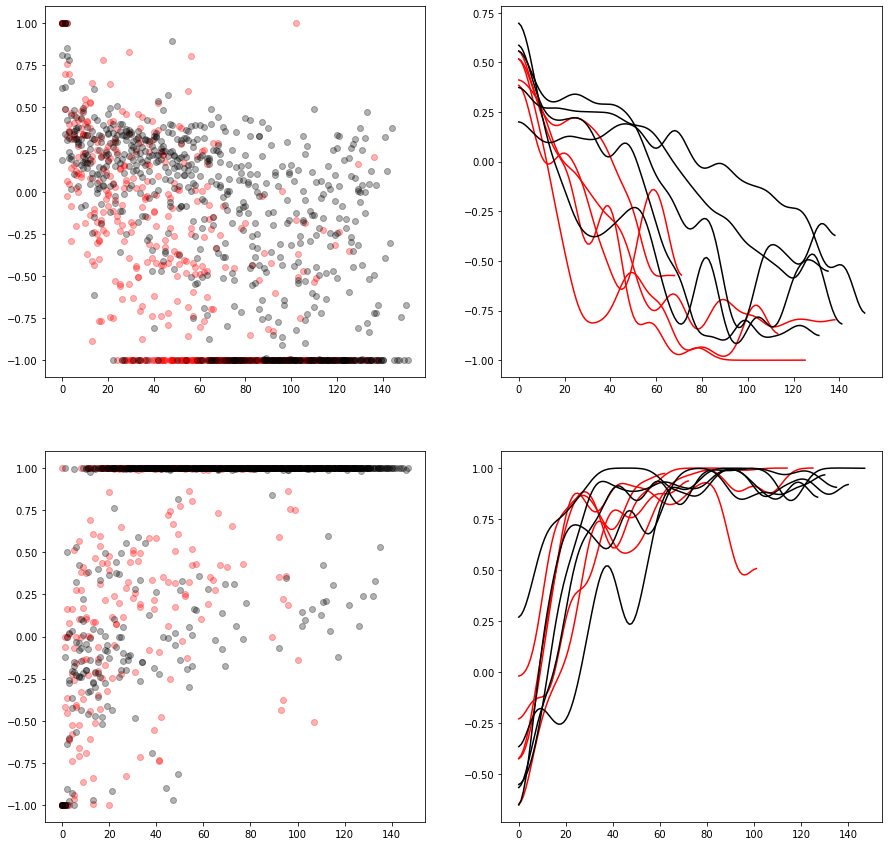

In [28]:
fig,ax = plt.subplots(2,2,figsize=[15,15])

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    lr_dp_early = []
    lr_dp_late = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:
            
            nonbaseline_inds = d['block_number']>=2
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_dp_early.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_dp_early = np.concatenate(lr_dp_early)
    lr_dp_late = np.concatenate(lr_dp_late)

    lr_early_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_early, 5)
    lr_late_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_late, 5)
    inds_early = np.arange(lr_dp_early.shape[0])
    ax[0,0].scatter(inds_early,lr_dp_early,color='red',alpha=.3)
    ax[0,1].plot(inds_early,lr_early_smooth,color='red')
    
    inds_late = np.arange(lr_dp_late.shape[0])
    ax[1,0].scatter(inds_late,lr_dp_late,color='red',alpha=.3)
    ax[1,1].plot(inds_late,lr_late_smooth,color='red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    lr_dp_early = []
    lr_dp_late = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:
            
            nonbaseline_inds = d['block_number']>=2
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_dp_early.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_dp_early = np.concatenate(lr_dp_early)
    lr_dp_late = np.concatenate(lr_dp_late)

    lr_early_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_early, 5)
    lr_late_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_late, 5)
    inds_early = np.arange(lr_dp_early.shape[0])
    ax[0,0].scatter(inds_early,lr_dp_early,color='black',alpha=.3)
    ax[0,1].plot(inds_early,lr_early_smooth,color='black')
    
    inds_late = np.arange(lr_dp_late.shape[0])
    ax[1,0].scatter(inds_late,lr_dp_late,color='black',alpha=.3)
    ax[1,1].plot(inds_late,lr_late_smooth,color='black')


In [ ]:
# omission rate

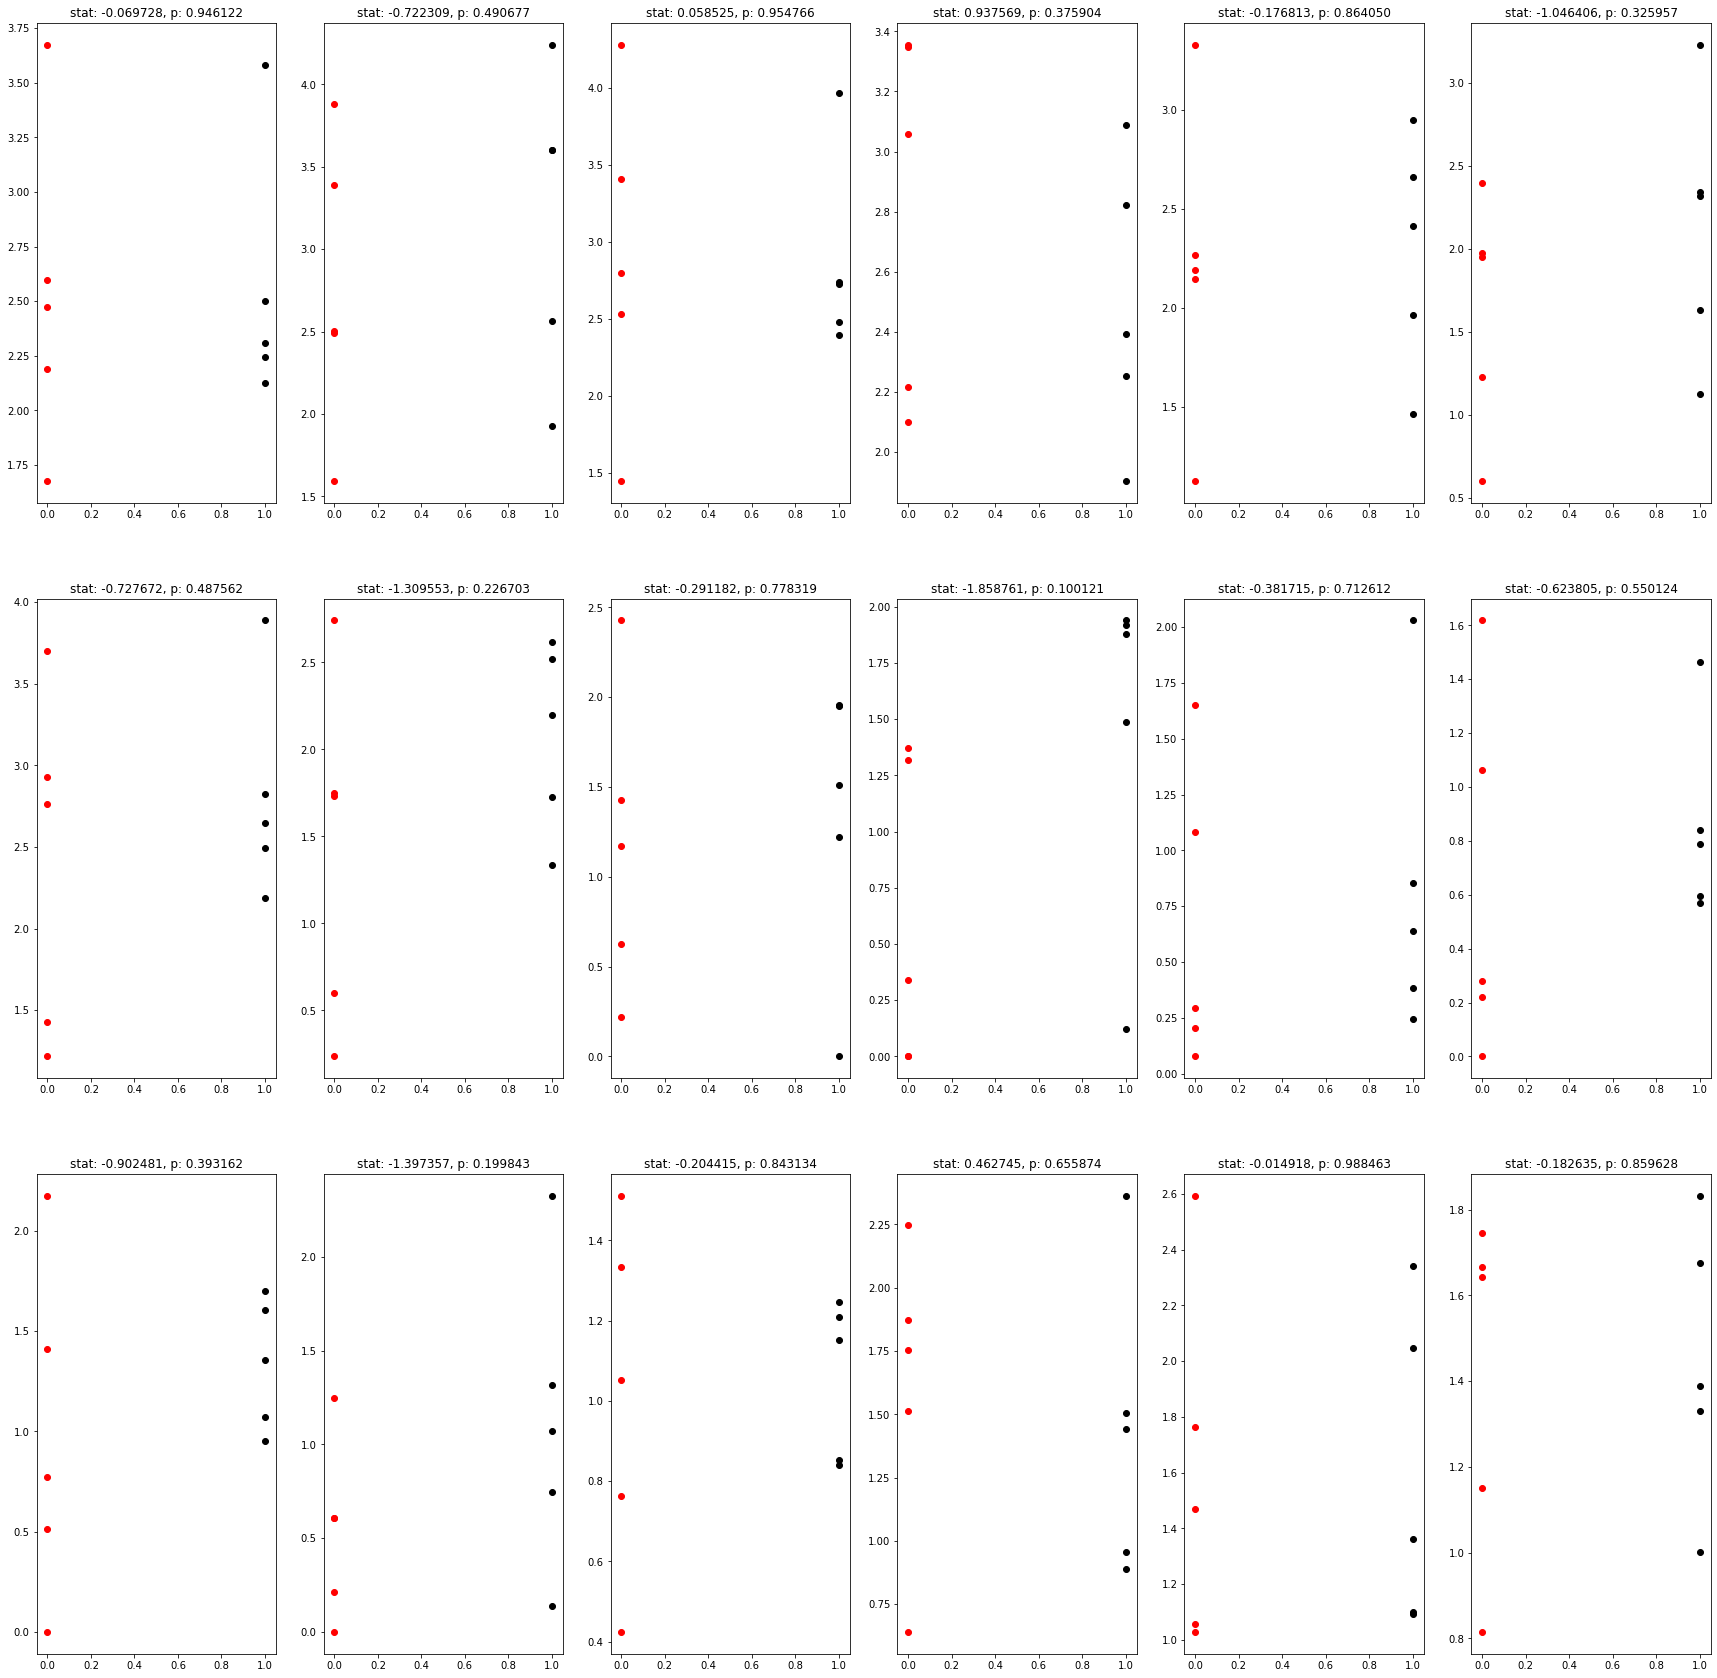

In [31]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
#         stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

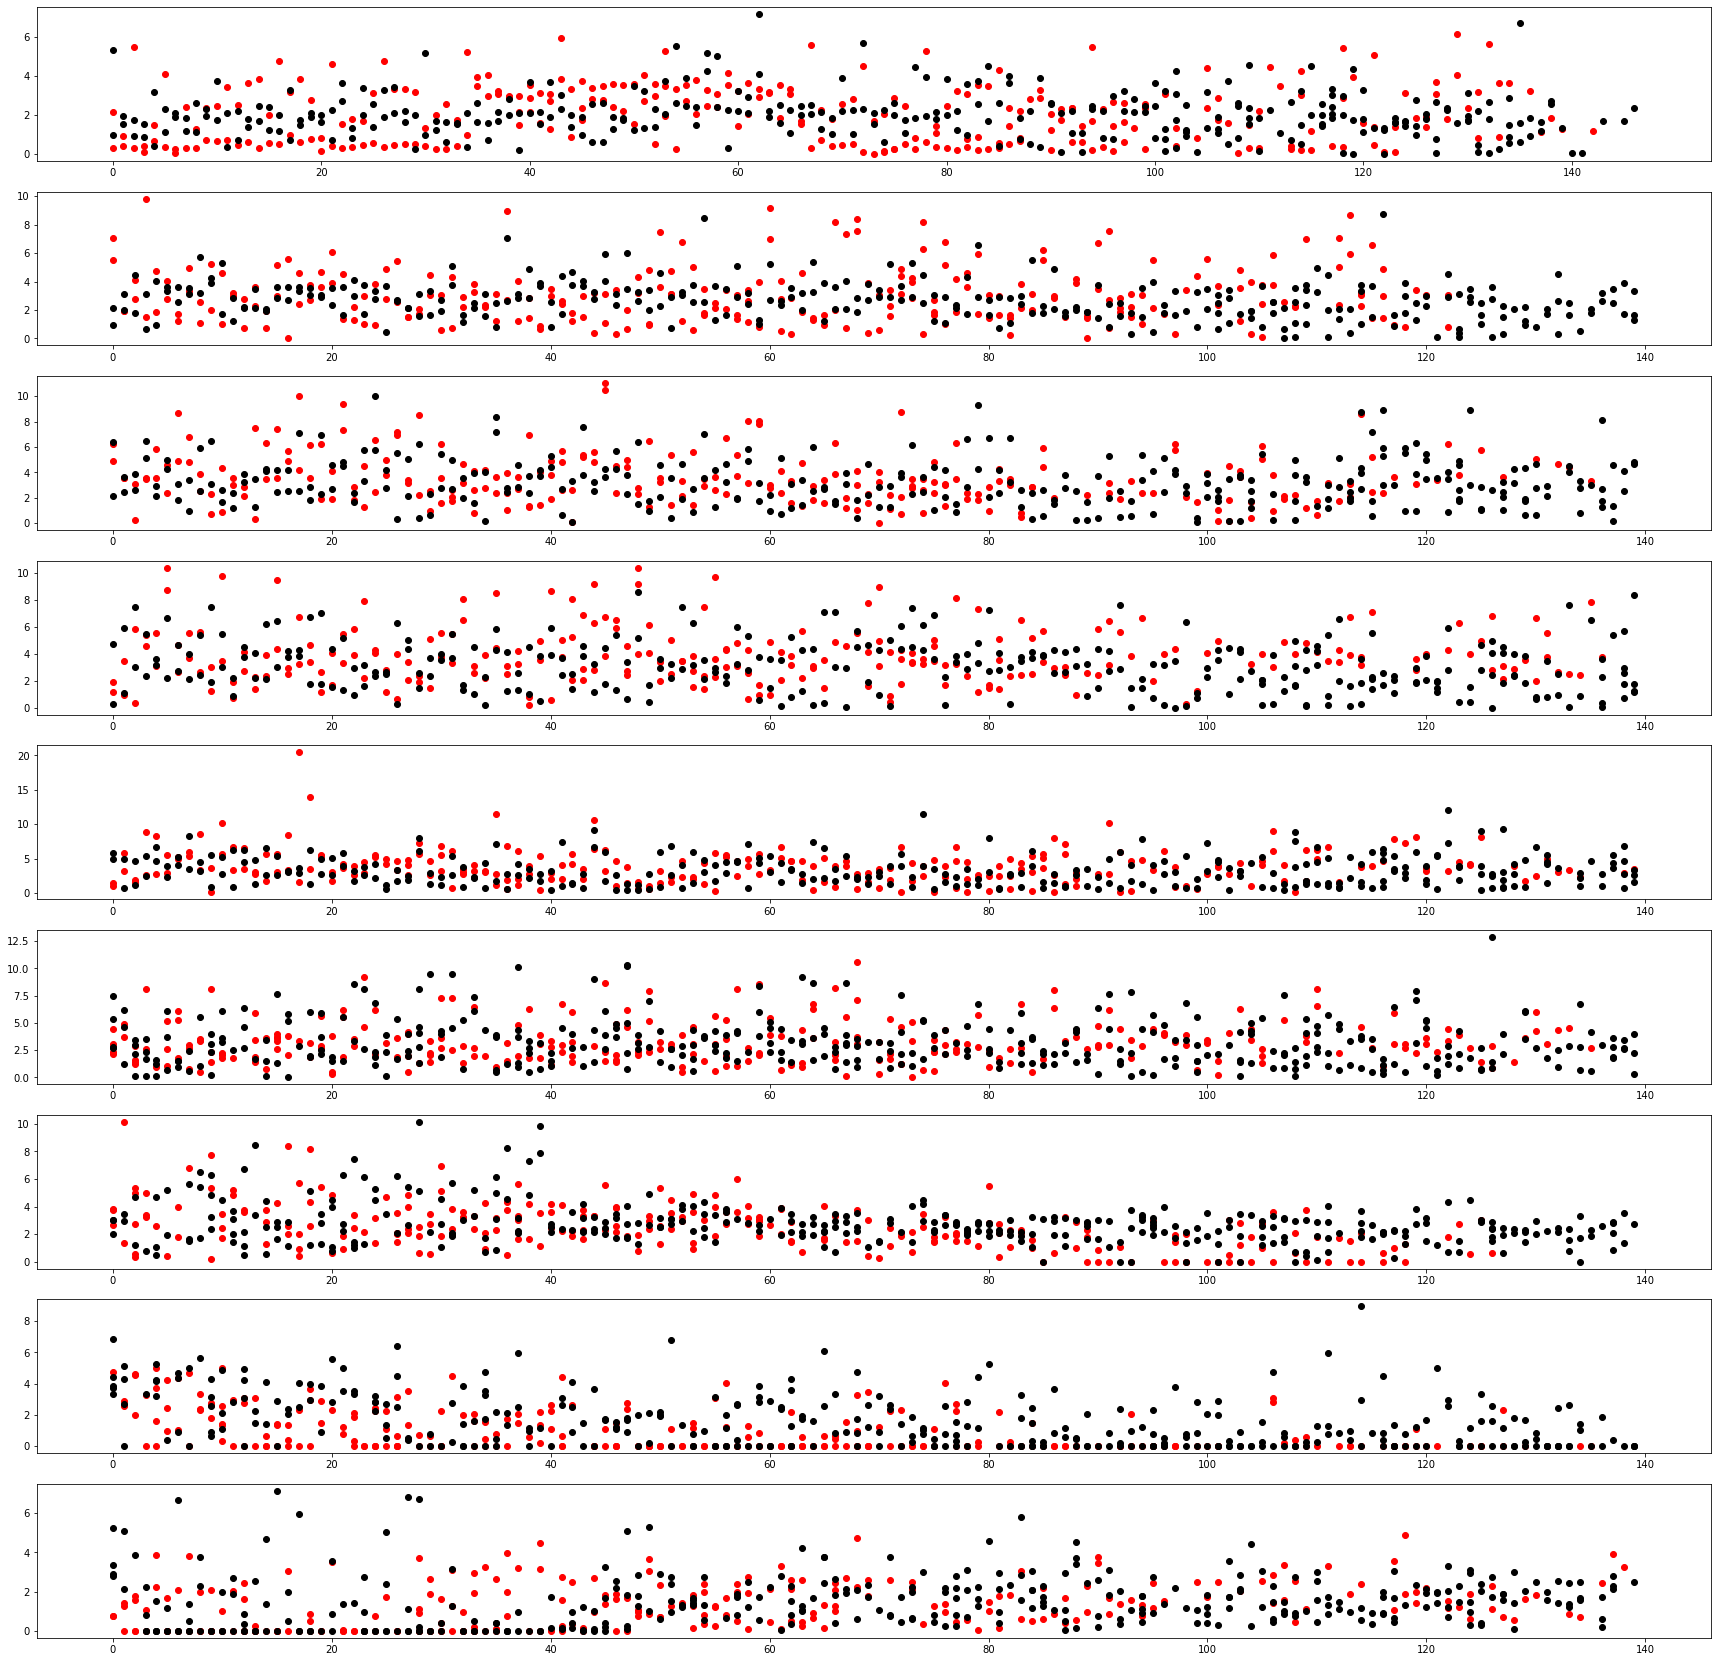

In [32]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'black')
    